In [492]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

import optuna

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import math
import warnings
warnings.filterwarnings("ignore")

In [252]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [253]:
train_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [254]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [255]:
train_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [256]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [257]:
train_df.dtypes[train_df.dtypes != 'object']

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [258]:
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = numeric_columns.drop('SalePrice')  # SalePrice'ı çıkarıyoruz

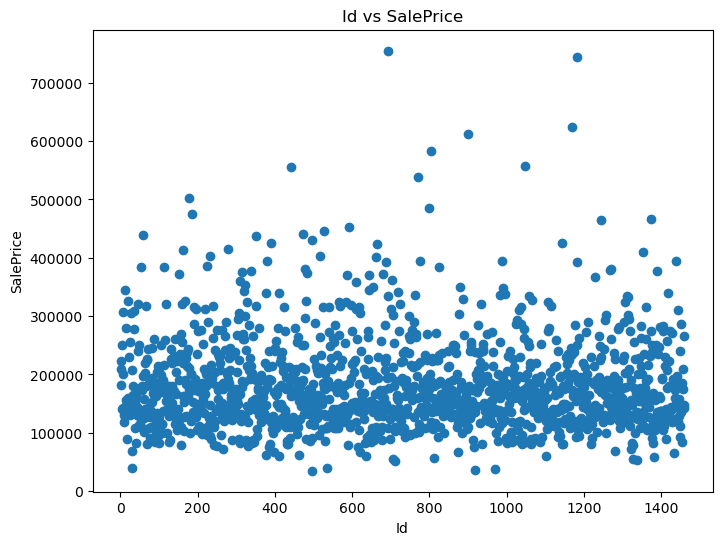

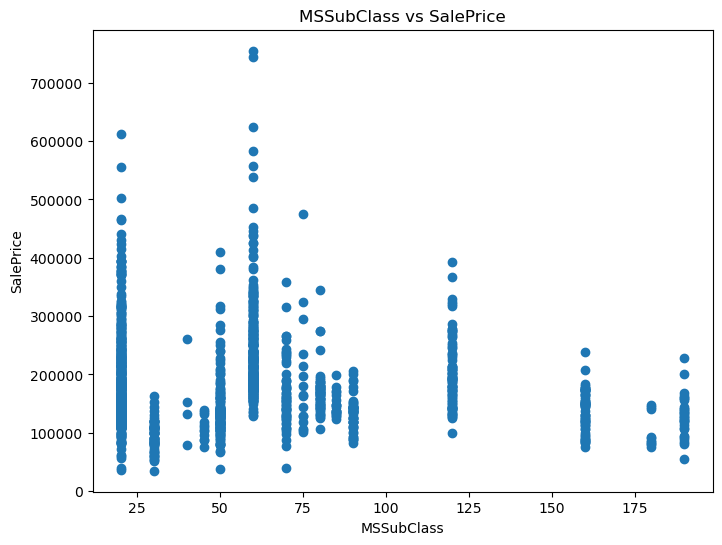

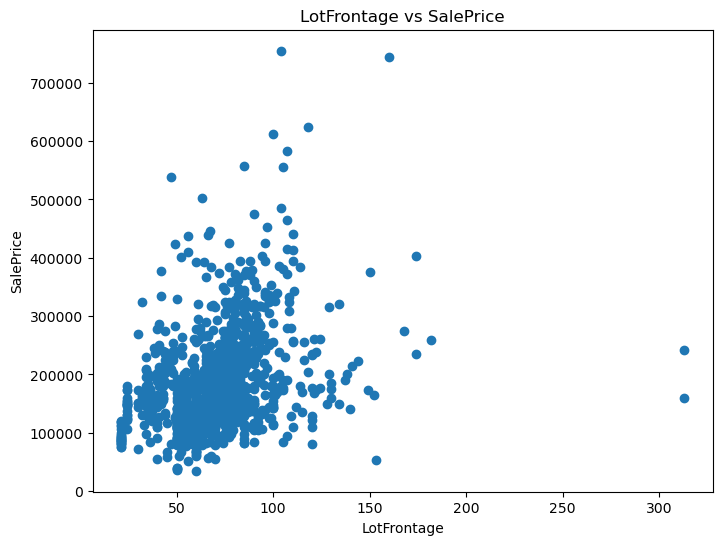

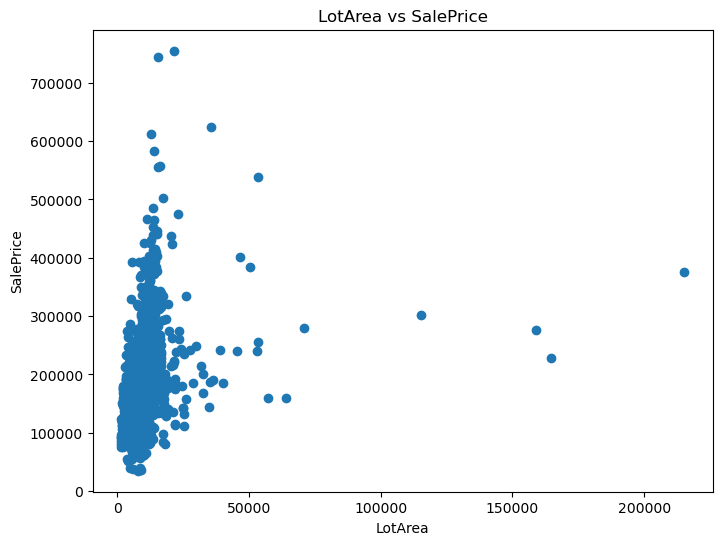

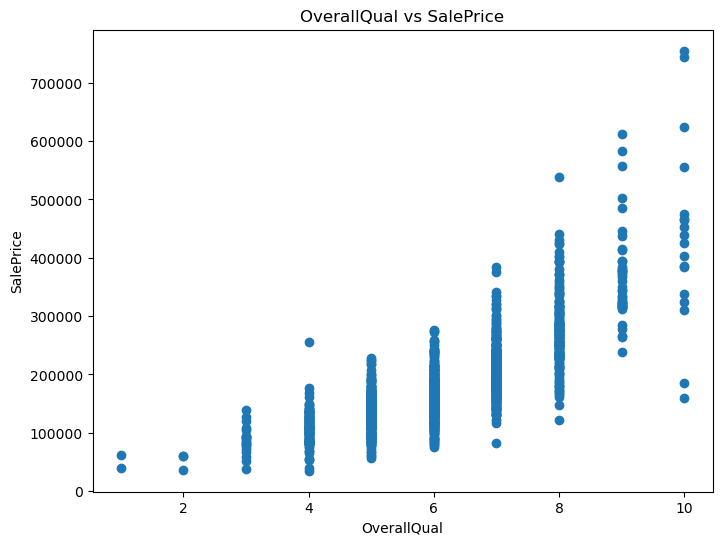

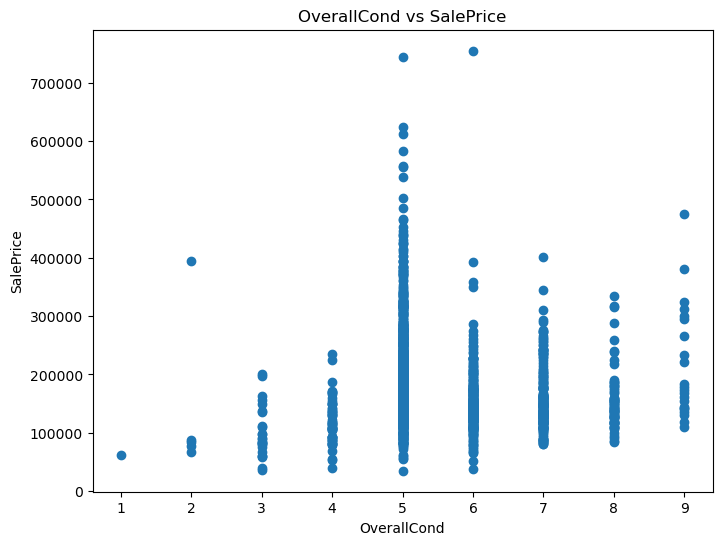

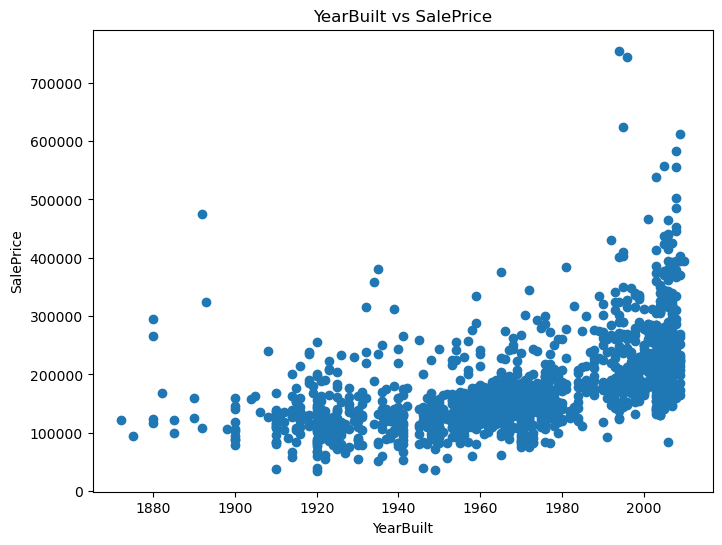

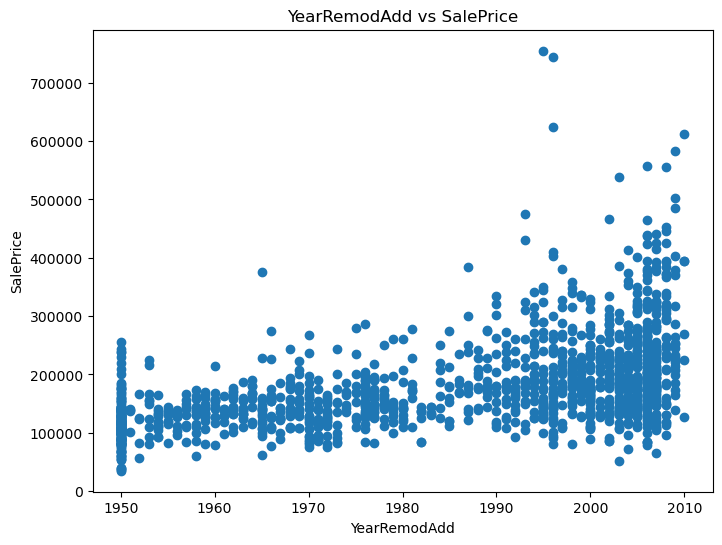

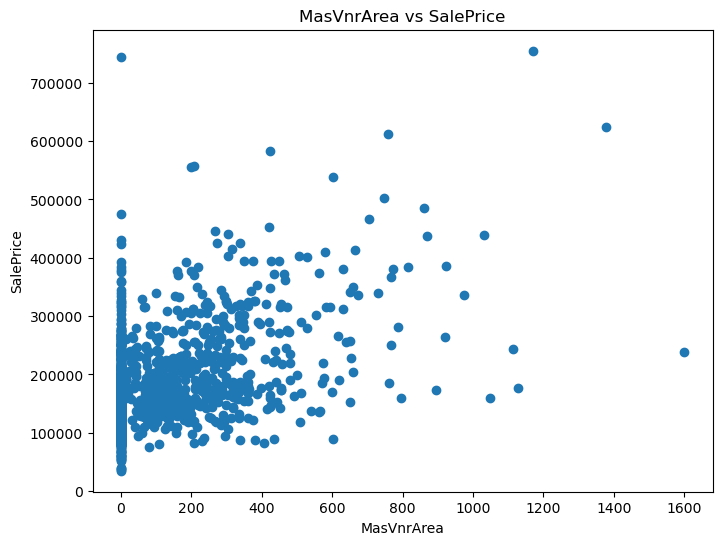

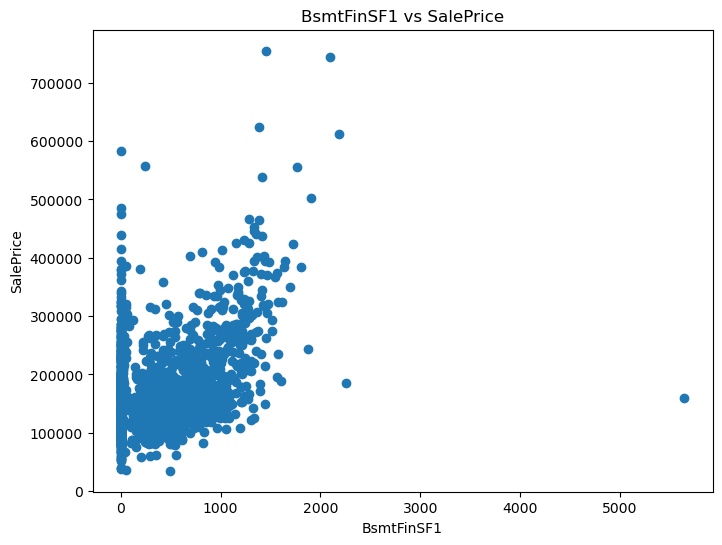

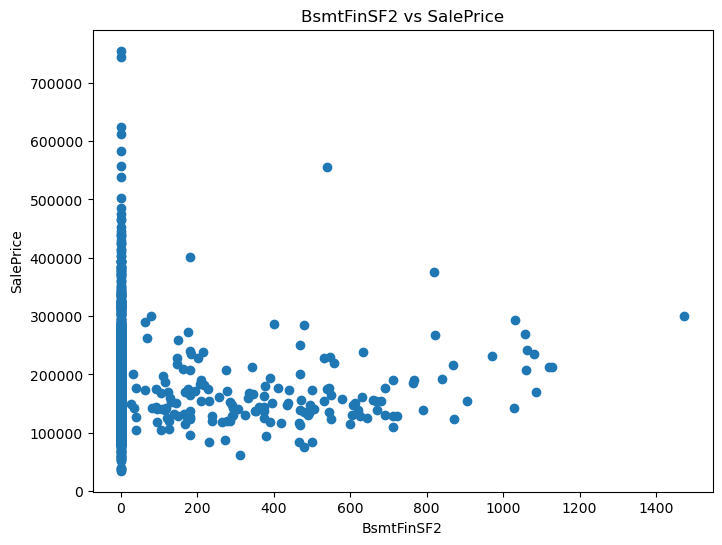

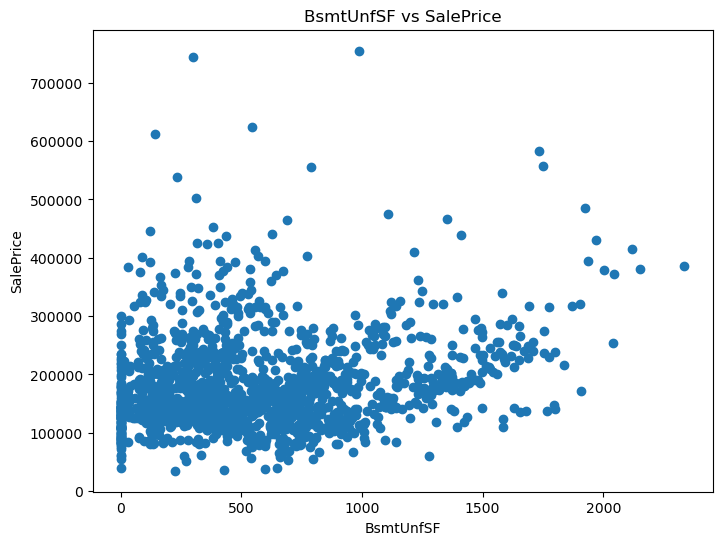

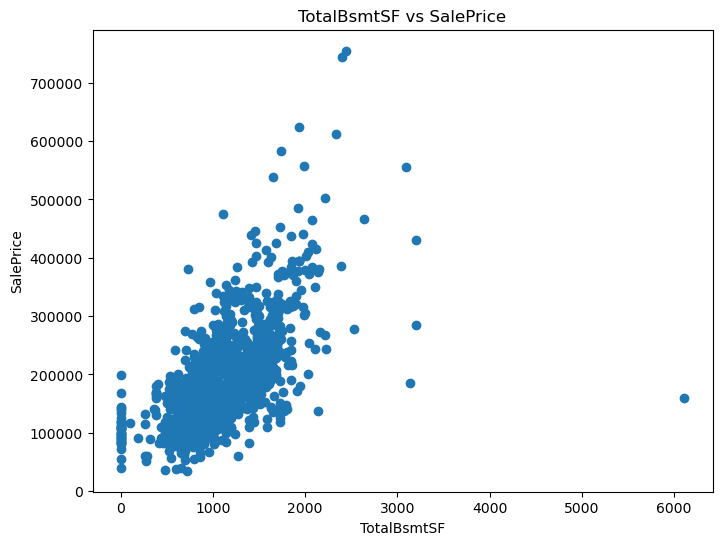

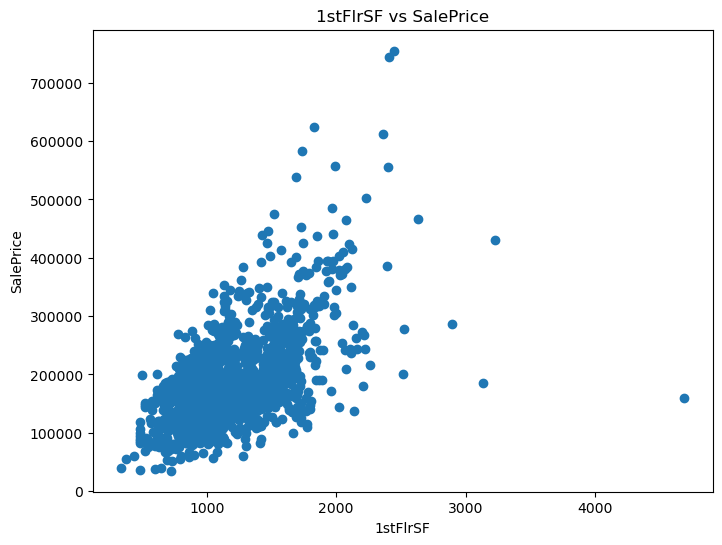

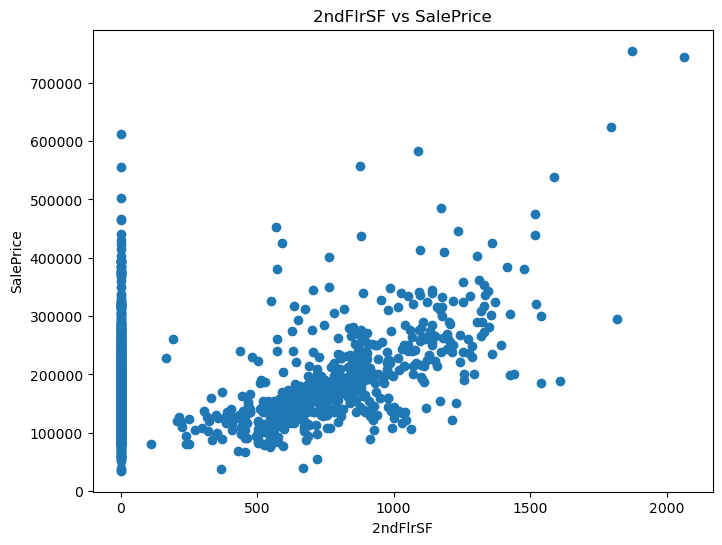

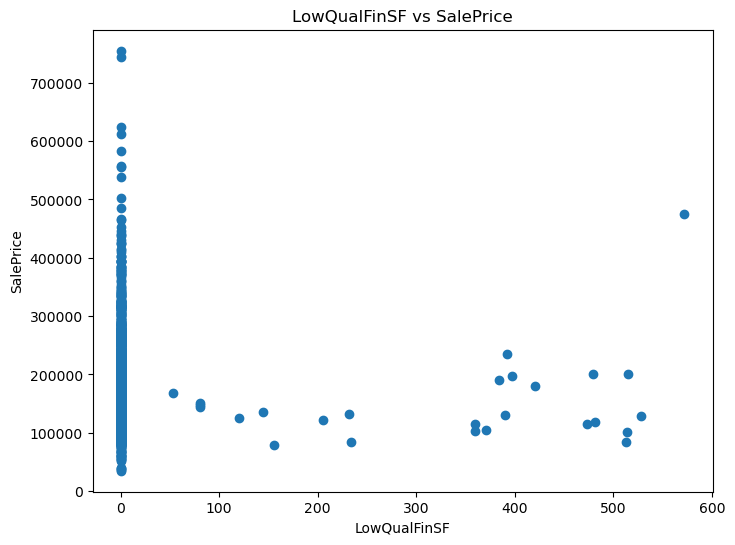

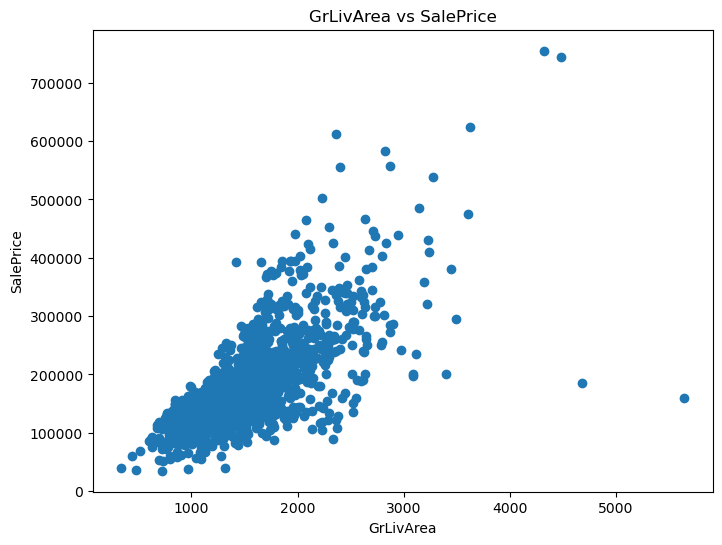

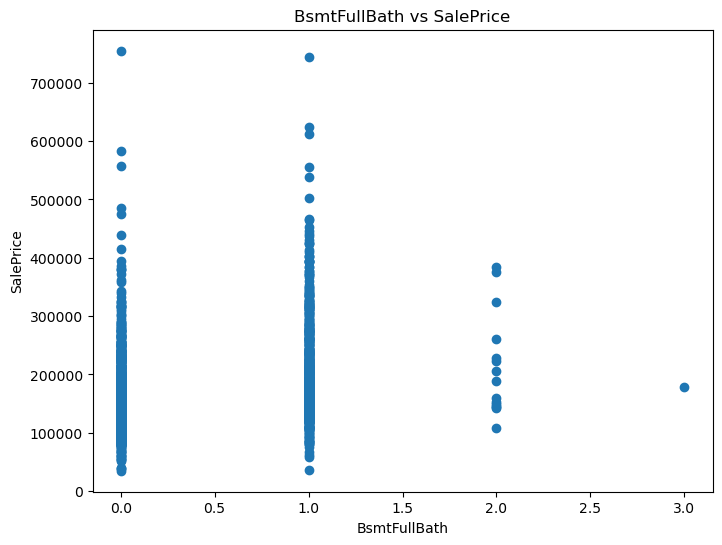

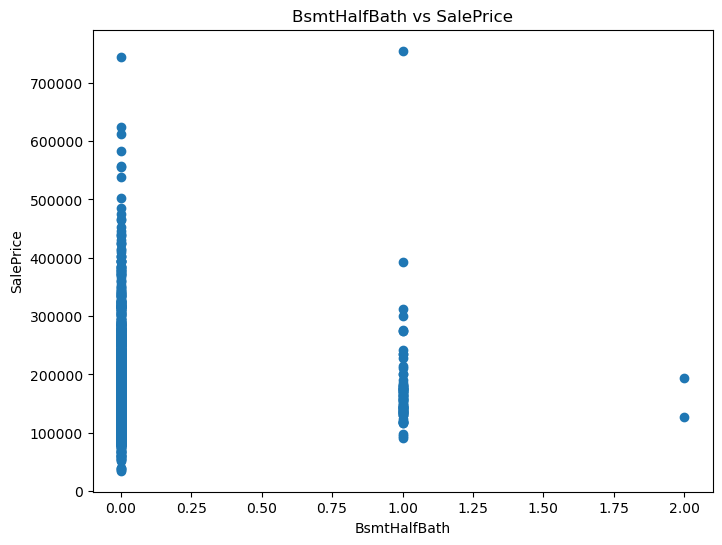

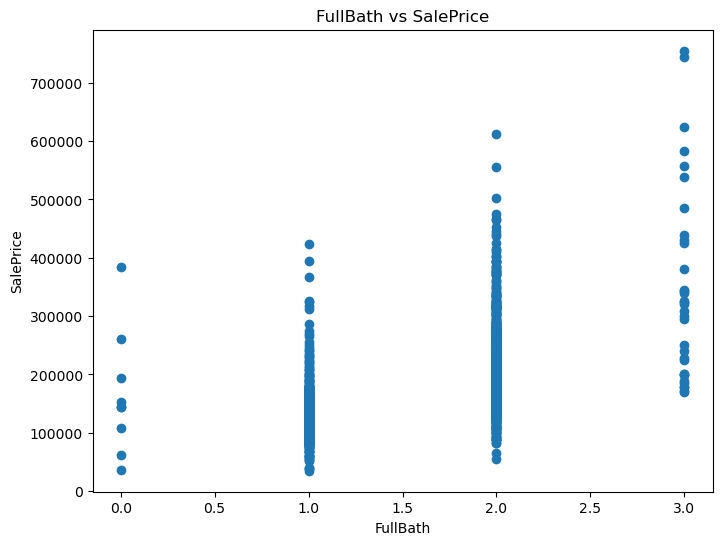

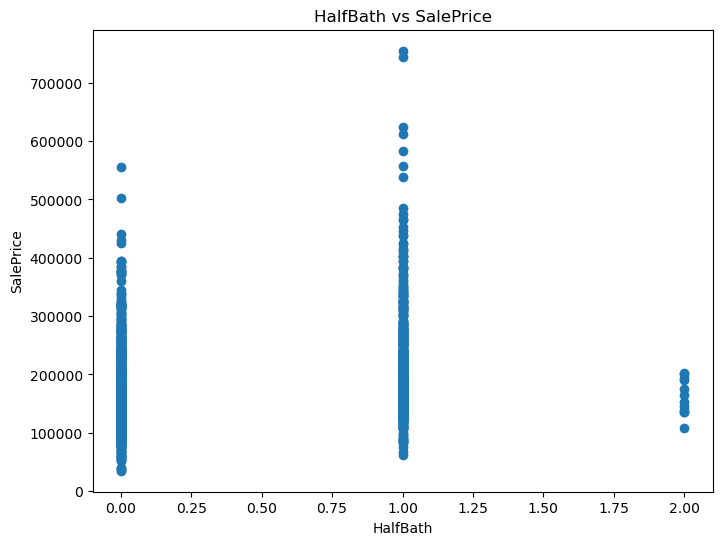

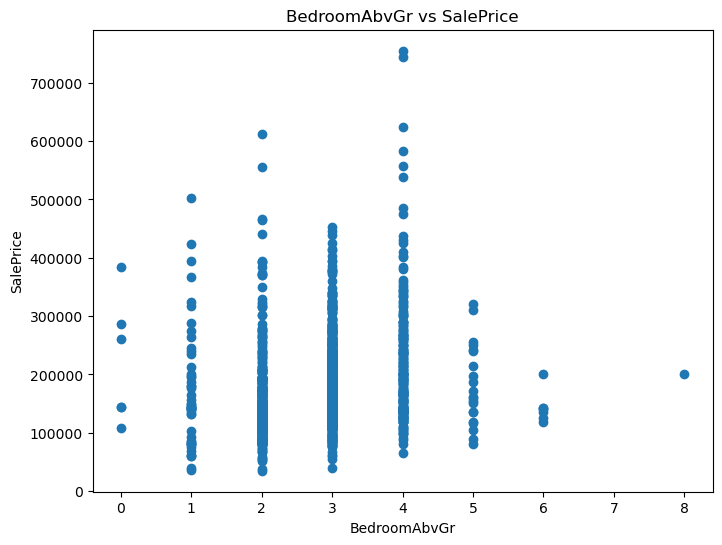

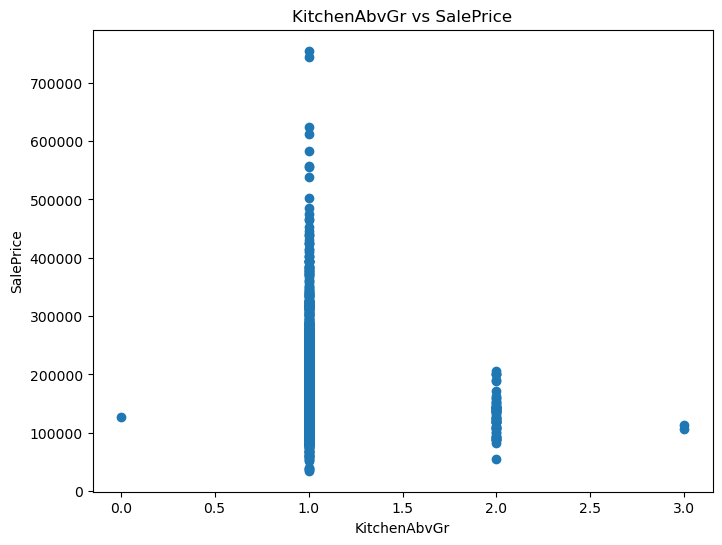

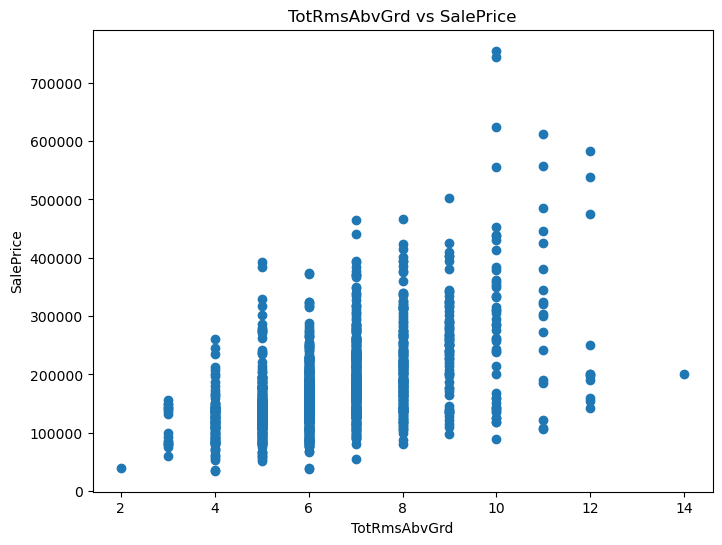

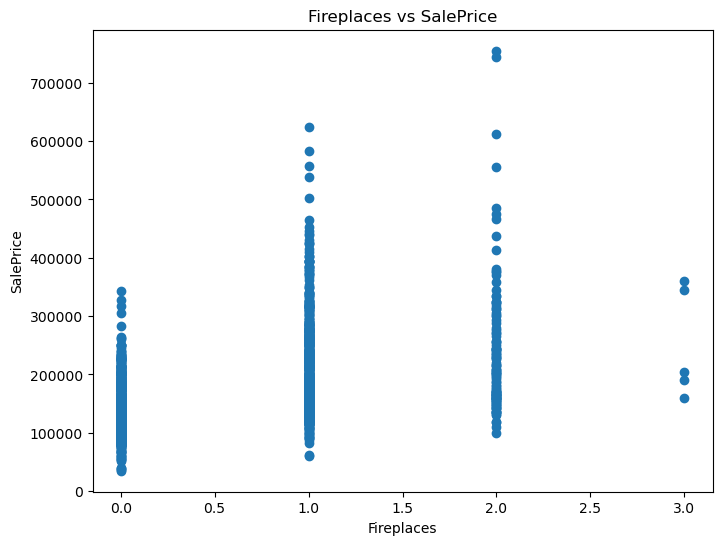

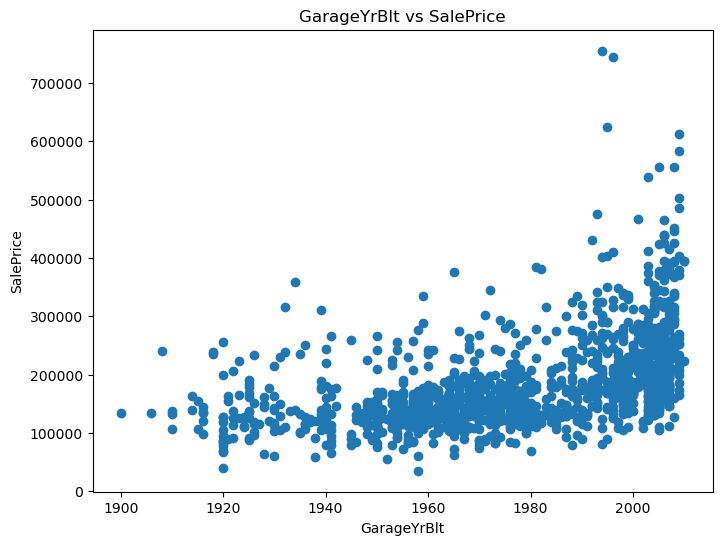

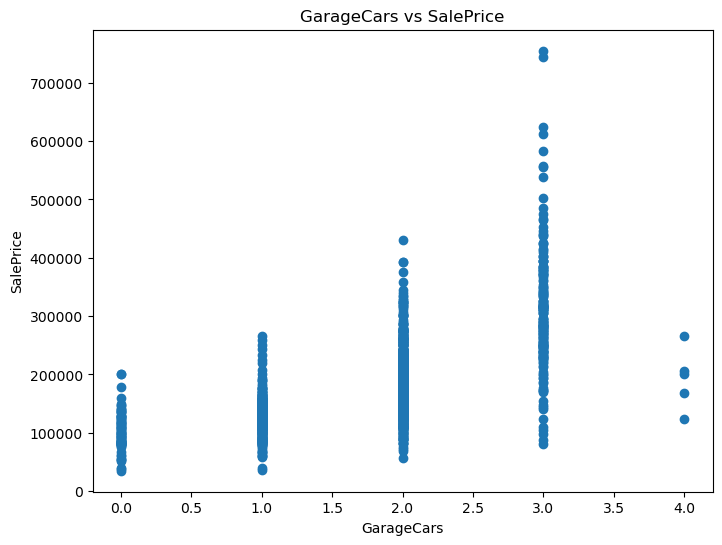

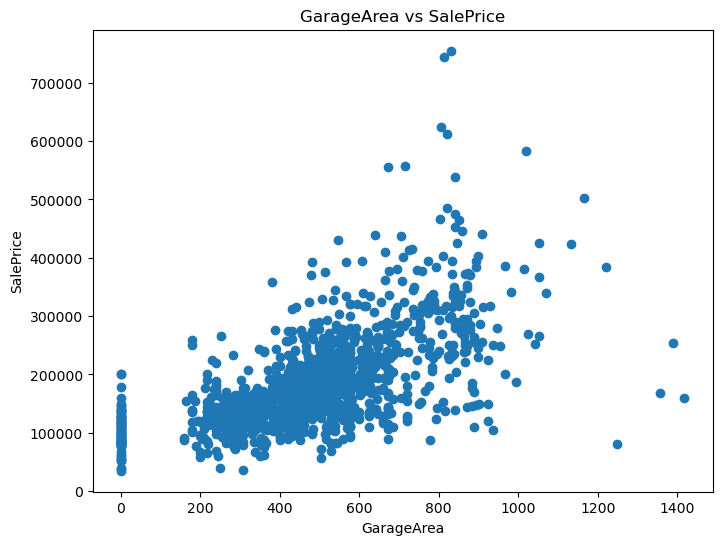

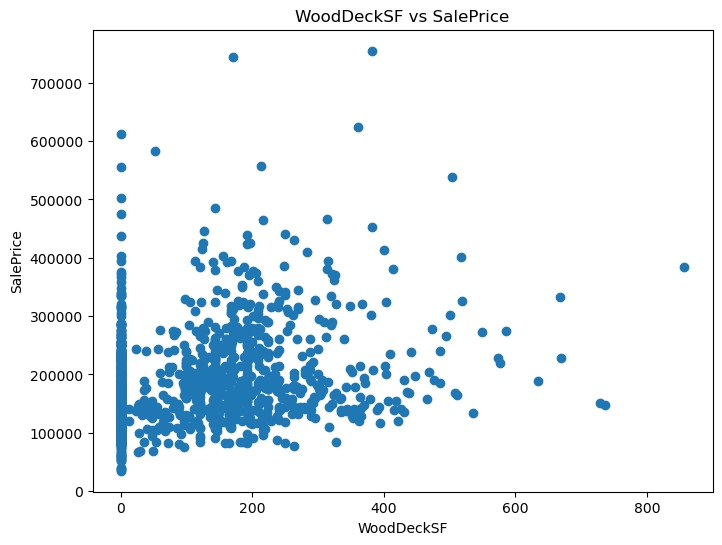

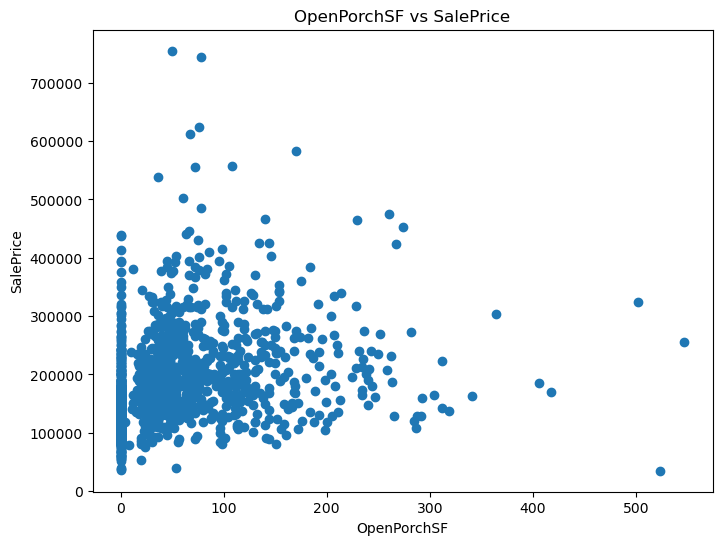

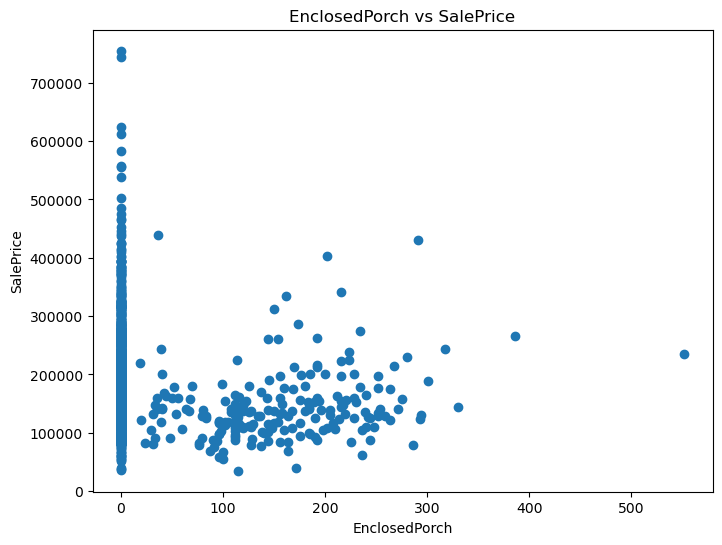

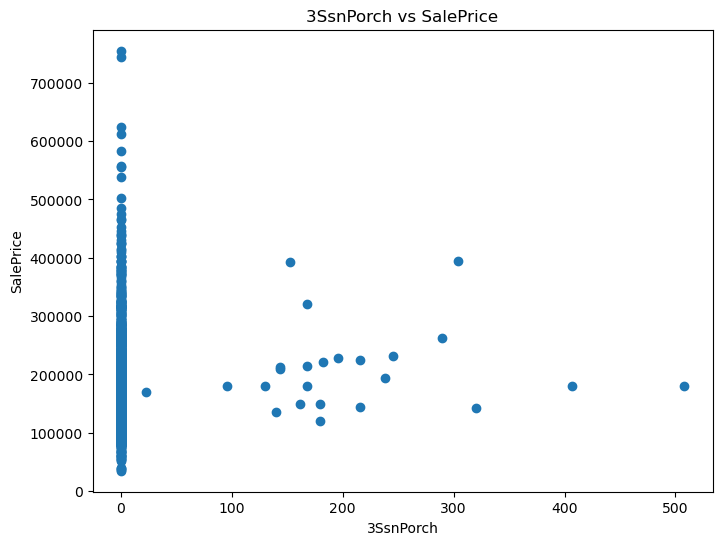

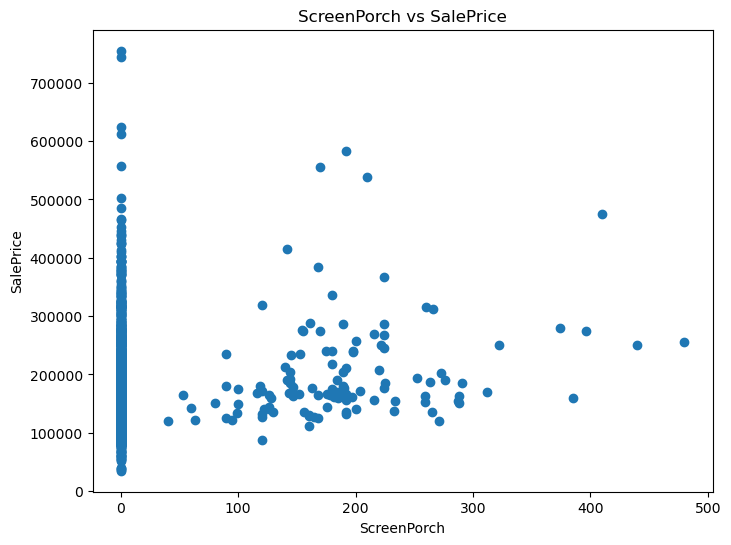

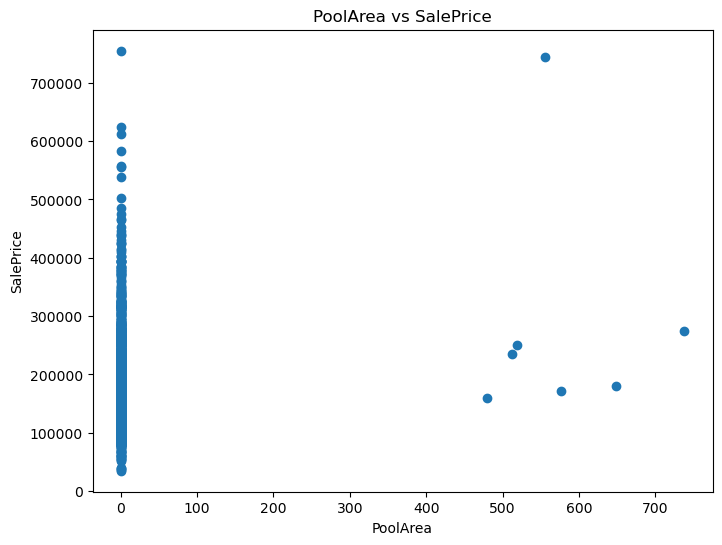

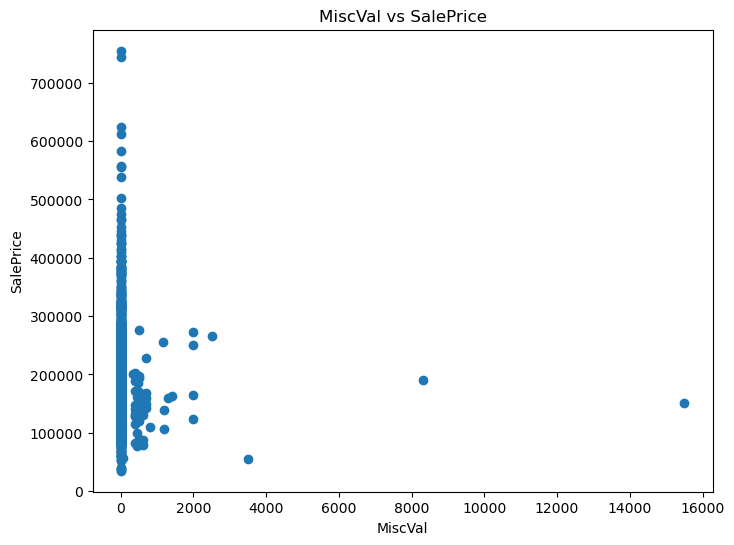

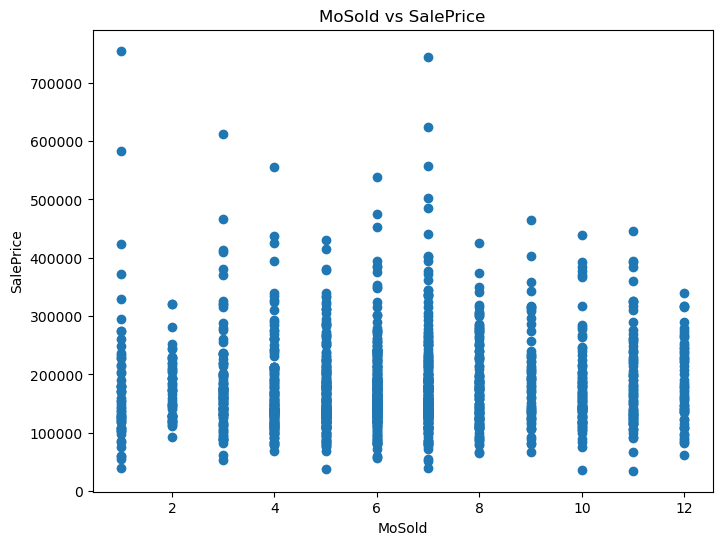

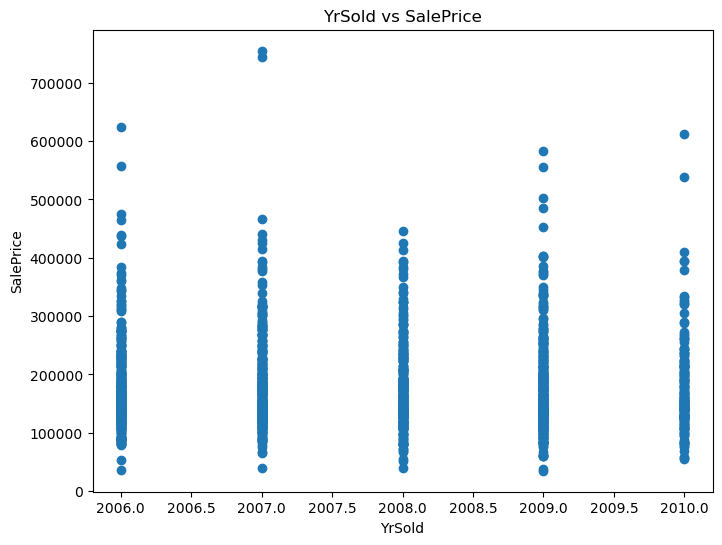

In [259]:
for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(x=train_df[col], y=train_df['SalePrice'])
    plt.title(f'{col} vs SalePrice')
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.show()

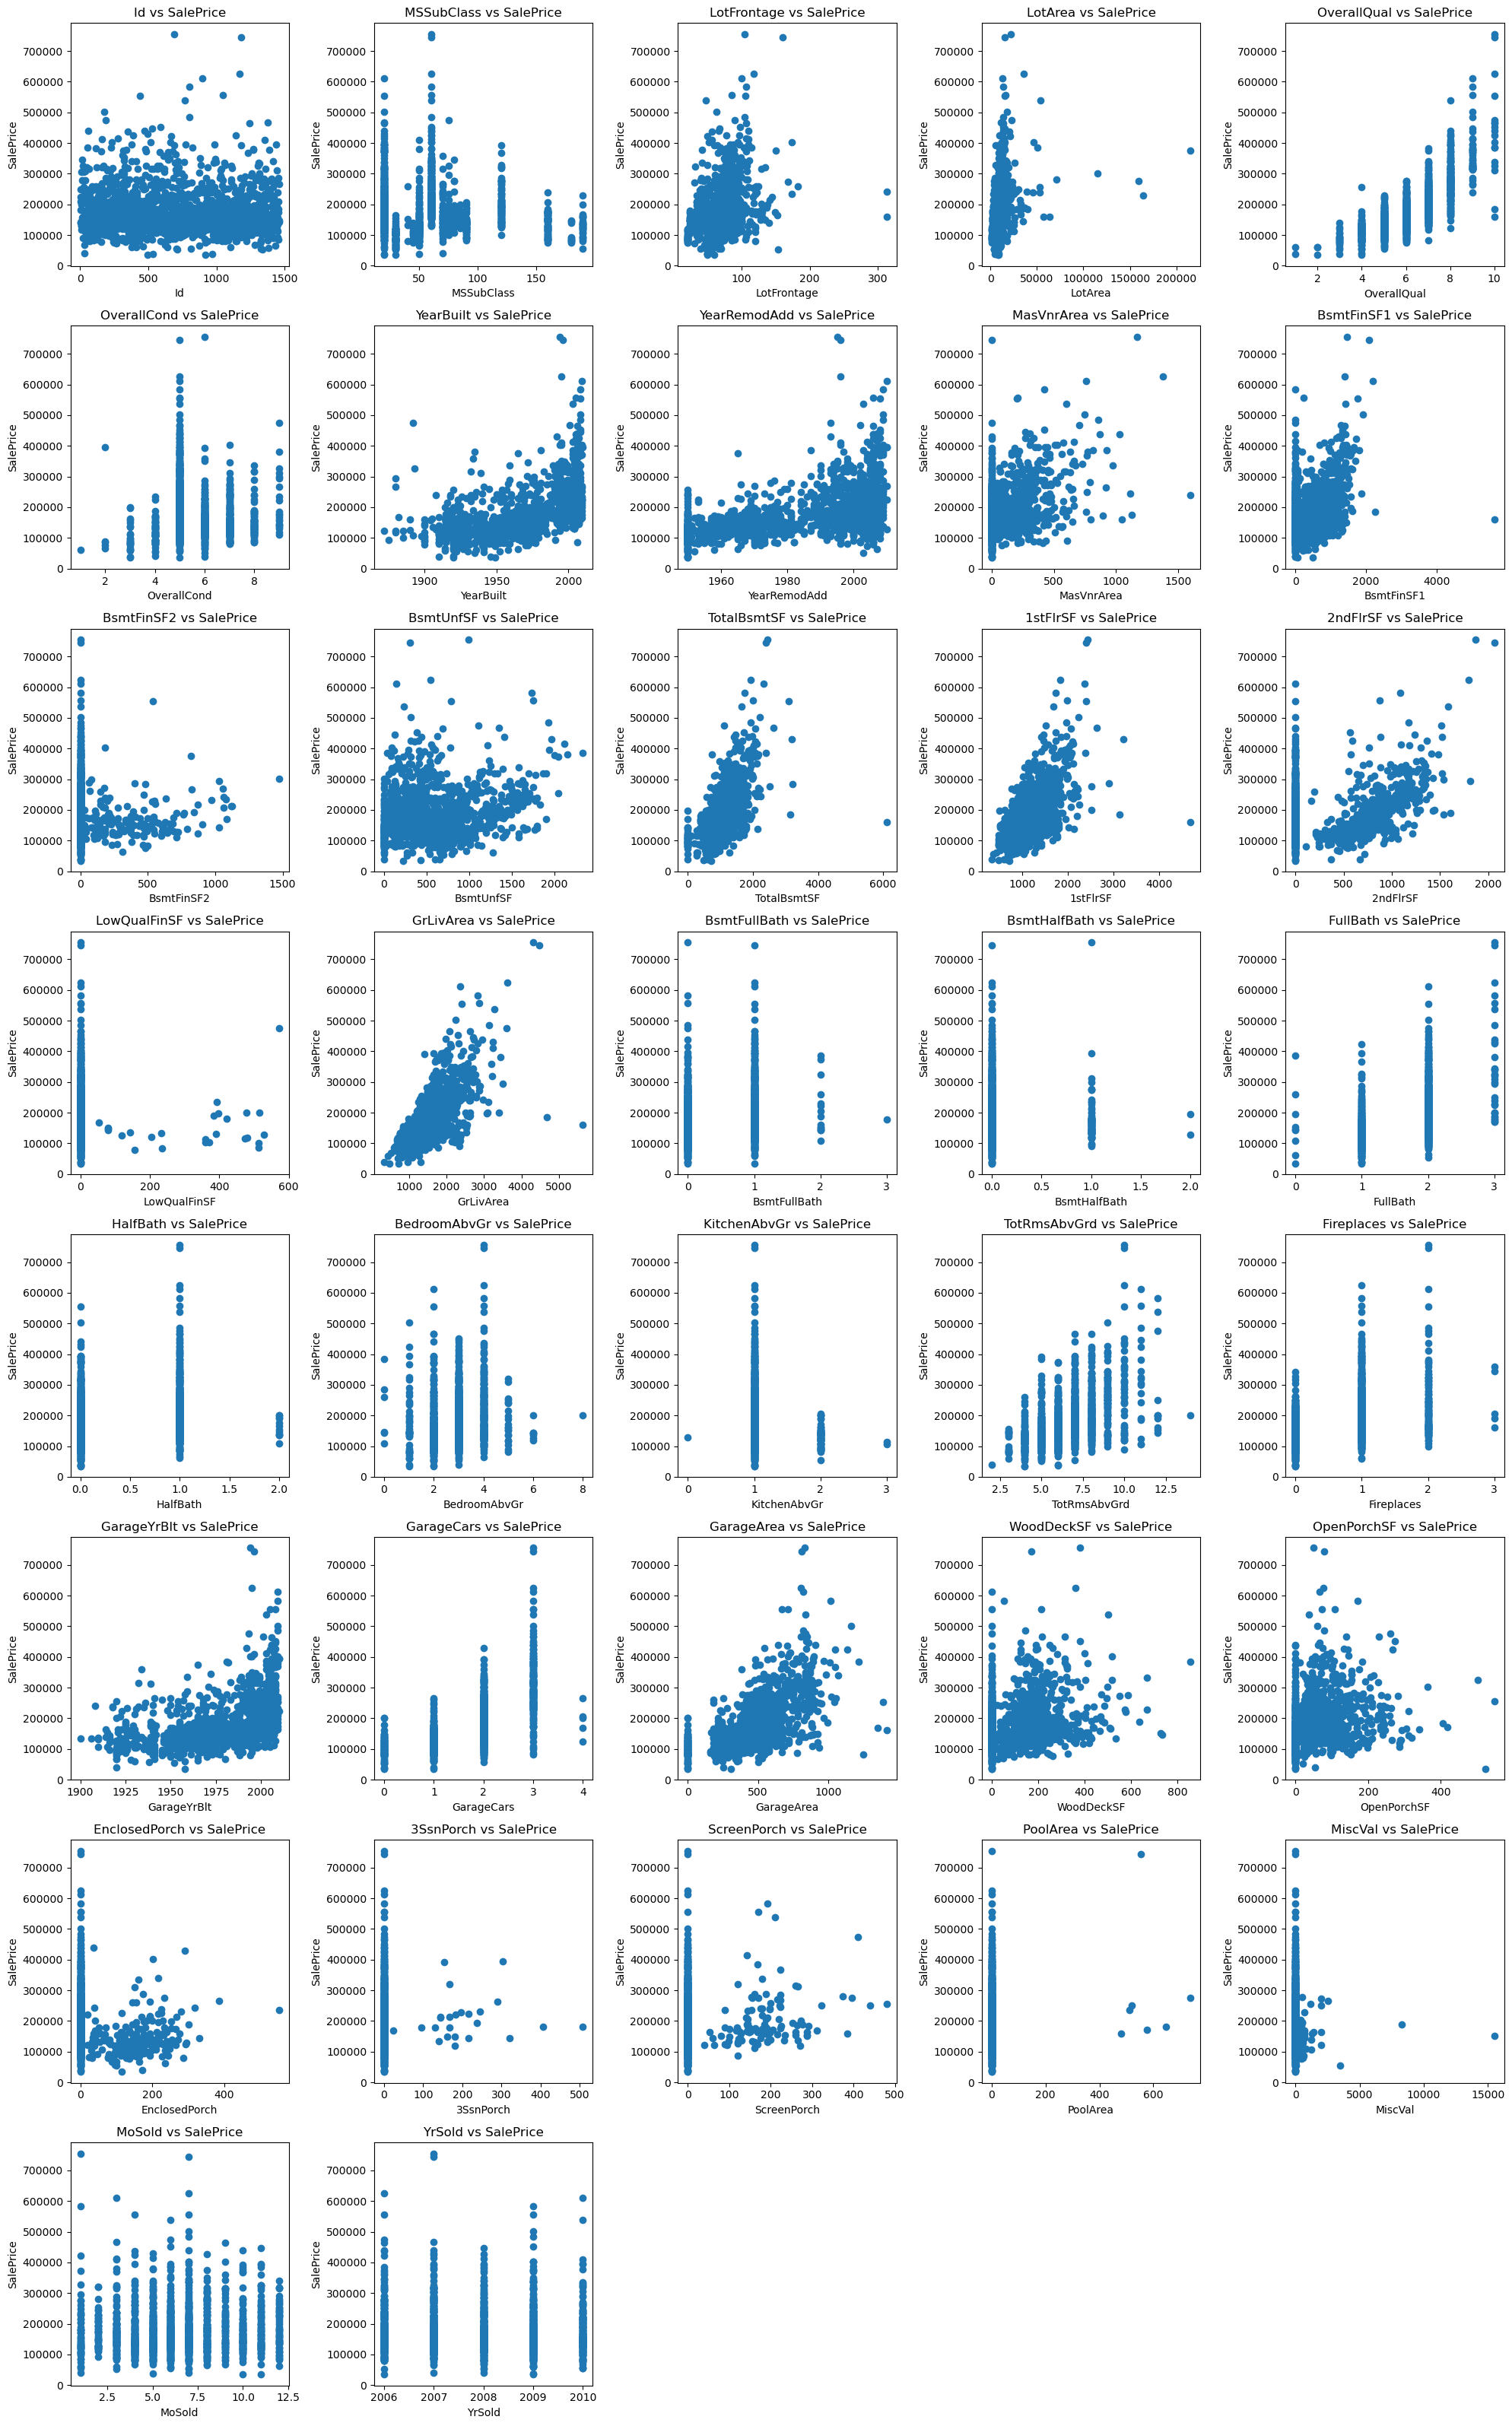

In [260]:
# SalePrice hariç tüm numeric kolonları seçelim
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = numeric_columns.drop('SalePrice')  # SalePrice'ı çıkarıyoruz

# Subplot düzenini belirlemek için satır ve sütun sayısı
n_cols = 5  # Bir satırda kaç grafik olacağını belirtiyoruz
n_rows = math.ceil(len(numeric_columns) / n_cols)  # Satır sayısını hesaplıyoruz

# Figür ve axis oluşturma
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()  # Axisleri düzleştiriyoruz 6,5 yerine 1,2,3,4,5...

# Her bir numeric kolon için scatter plot oluşturma
for i, col in enumerate(numeric_columns):
    axes[i].scatter(x=train_df[col], y=train_df['SalePrice'])
    axes[i].set_title(f'{col} vs SalePrice')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('SalePrice')

# Boş kalan subplot'ları gizleme
for i in range(len(numeric_columns), n_rows * n_cols):
    fig.delaxes(axes[i])#Boş kalan subplot'ları figürden kaldırır.

plt.tight_layout()
plt.show()

In [261]:
train_df.query('LotFrontage > 300')
#Drop 935, 1299

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
934    935          20       RL        313.0    27650   Pave   NaN      IR2   
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
934          HLS    AllPub  ...        0    NaN   NaN         NaN       0   
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
934      11   2008        WD         Normal     242000  
1298      1   2008       New        Partial     160000  

[2 rows x 81 columns]

In [262]:
train_df.query('LotArea > 55000')
# 250, 314, 336, 707
#maybe 1397

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
249    250          50       RL          NaN   159000   Pave   NaN      IR2   
313    314          20       RL        150.0   215245   Pave   NaN      IR3   
335    336         190       RL          NaN   164660   Grvl   NaN      IR1   
451    452          20       RL         62.0    70761   Pave   NaN      IR1   
706    707          20       RL          NaN   115149   Pave   NaN      IR2   
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   
1396  1397          20       RL          NaN    57200   Pave   NaN      IR1   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
249          Low    AllPub  ...        0    NaN   NaN        Shed     500   
313          Low    AllPub  ...        0    NaN   NaN         NaN       0   
335          HLS    AllPub  ...        0    NaN   NaN        Shed     700   
451          Low    AllPub  ...        0    NaN   NaN         NaN       0   
706          Low    AllPub  ...        0    NaN   NaN         NaN       0   
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   
1396         Bnk    AllPub  ...        0    NaN   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
249       6   2007        WD         Normal     277000  
313       6   2009        WD         Normal     375000  
335       8   2008        WD         Normal     228950  
451      12   2006        WD         Normal     280000  
706       6   2007        WD         Normal     302000  
1298      1   2008       New        Partial     160000  
1396      6   2010        WD         Normal     160000  

[7 rows x 81 columns]

In [263]:
stats.zscore(train_df['LotArea']).sort_values().tail(10)

384      4.268474
457      4.280500
769      4.308262
1396     4.678682
1298     5.348867
451      6.037793
706     10.486449
249     14.881285
335     15.448542
313     20.518273
Name: LotArea, dtype: float64

In [264]:
train_df.query('OverallQual == 10')
#maybe 524

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
58      59          60       RL         66.0    13682   Pave   NaN      IR2   
185    186          75       RM         90.0    22950   Pave   NaN      IR2   
224    225          20       RL        103.0    13472   Pave   NaN      Reg   
389    390          60       RL         96.0    12474   Pave   NaN      Reg   
440    441          20       RL        105.0    15431   Pave   NaN      Reg   
515    516          20       RL         94.0    12220   Pave   NaN      Reg   
523    524          60       RL        130.0    40094   Pave   NaN      IR1   
583    584          75       RM         75.0    13500   Pave   NaN      Reg   
591    592          60       RL         97.0    13478   Pave   NaN      IR1   
691    692          60       RL        104.0    21535   Pave   NaN      IR1   
825    826          20       RL        114.0    14803   Pave   NaN      Reg   
994    995          20       RL         96.0    12456   Pave   NaN      Reg   
1169  1170          60       RL        118.0    35760   Pave   NaN      IR1   
1182  1183          60       RL        160.0    15623   Pave   NaN      IR1   
1243  1244          20       RL        107.0    13891   Pave   NaN      Reg   
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   
1373  1374          20       RL          NaN    11400   Pave   NaN      Reg   
1442  1443          60       FV         85.0    11003   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
58           HLS    AllPub  ...        0    NaN    NaN         NaN       0   
185          Lvl    AllPub  ...        0    NaN  GdPrv         NaN       0   
224          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
389          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
440          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
515          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
523          Bnk    AllPub  ...        0    NaN    NaN         NaN       0   
583          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
591          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
691          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
825          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
994          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1169         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1182         Lvl    AllPub  ...      555     Ex  MnPrv         NaN       0   
1243         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1298         Bnk    AllPub  ...      480     Gd    NaN         NaN       0   
1373         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1442         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
58       10   2006       New        Partial     438780  
185       6   2006        WD         Normal     475000  
224       6   2009        WD         Normal     386250  
389       8   2008       New        Partial     426000  
440       4   2009        WD         Normal     555000  
515       9   2009       New        Partial     402861  
523      10   2007       New        Partial     184750  
583       7   2008        WD         Normal     325000  
591       6   2009     ConLI         Normal     451950  
691       1   2007        WD         Normal     755000  
825       6   2008       New        Partial     385000  
994       7   2009        WD         Normal     337500  
1169      7   2006        WD         Normal     625000  
1182      7   2007        WD        Abnorml     745000  
1243      9   2006       New        Partial     465000  
1298      1   2008       New        Partial     160000  
1373      3   2007        WD         Normal     466500

In [265]:
train_df.query('OverallCond == 2')
#379

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
88    89          50  C (all)        105.0     8470   Pave   NaN      IR1   
250  251          30       RL         55.0     5350   Pave   NaN      IR1   
378  379          20       RL         88.0    11394   Pave   NaN      Reg   
398  399          30       RM         60.0     8967   Pave   NaN      Reg   
676  677          70       RM         60.0     9600   Pave  Grvl      Reg   

    LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
88          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
250         Lvl    AllPub  ...        0    NaN   GdWo        Shed     450   
378         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
398         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
676         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
88      10   2009     ConLD        Abnorml      85000  
250      5   2010        WD         Normal      76500  
378      6   2010       New        Partial     394432  
398     11   2007        WD        Abnorml      67000  
676      5   2006        WD         Normal      87000  

[5 rows x 81 columns]

In [266]:
train_df.query('OverallCond == 5 & SalePrice > 700000')
#1183

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1182  1183          60       RL        160.0    15623   Pave   NaN      IR1   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
1182         Lvl    AllPub  ...      555     Ex  MnPrv         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1182      7   2007        WD        Abnorml     745000  

[1 rows x 81 columns]

In [267]:
train_df.query('OverallCond == 6 & SalePrice > 700000')
#692

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
691  692          60       RL        104.0    21535   Pave   NaN      IR1   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
691         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
691      1   2007        WD         Normal     755000  

[1 rows x 81 columns]

In [268]:
train_df.query('YearBuilt < 1900 & SalePrice > 400000')
#186

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
185  186          75       RM         90.0    22950   Pave   NaN      IR2   

    LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
185         Lvl    AllPub  ...        0    NaN  GdPrv         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
185      6   2006        WD         Normal     475000  

[1 rows x 81 columns]

In [269]:
train_df.query('YearRemodAdd < 1970 & SalePrice > 300000')
#314

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
313  314          20       RL        150.0   215245   Pave   NaN      IR3   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
313         Low    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
313      6   2009        WD         Normal     375000  

[1 rows x 81 columns]

In [270]:
train_df.query('MasVnrArea > 1500')
#298

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
297  298          60       FV         66.0     7399   Pave  Pave      IR1   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
297         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
297      6   2007        WD         Normal     239000  

[1 rows x 81 columns]

In [271]:
train_df.query('BsmtFinSF1 > 5000')
#1299

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1298      1   2008       New        Partial     160000  

[1 rows x 81 columns]

In [272]:
train_df.query('BsmtFinSF2 > 400 & SalePrice > 500000')
#441

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
440  441          20       RL        105.0    15431   Pave   NaN      Reg   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
440         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
440      4   2009        WD         Normal     555000  

[1 rows x 81 columns]

In [273]:
train_df.query('TotalBsmtSF > 5000')
#1299

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1298      1   2008       New        Partial     160000  

[1 rows x 81 columns]

In [274]:
train_df.query('LowQualFinSF > 500')
#186

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
88      89          50  C (all)        105.0     8470   Pave   NaN      IR1   
170    171          50       RM          NaN    12358   Pave   NaN      IR1   
185    186          75       RM         90.0    22950   Pave   NaN      IR2   
635    636         190       RH         60.0    10896   Pave  Pave      Reg   
1009  1010          50       RL         60.0     6000   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
88           Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
170          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
185          Lvl    AllPub  ...        0    NaN  GdPrv         NaN       0   
635          Bnk    AllPub  ...        0    NaN    NaN         NaN       0   
1009         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
88       10   2009     ConLD        Abnorml      85000  
170       5   2007        WD         Normal     128500  
185       6   2006        WD         Normal     475000  
635       3   2007        WD        Abnorml     200000  
1009      6   2006        WD         Normal     102000  

[5 rows x 81 columns]

In [275]:
train_df.query('GrLivArea > 4400')
#524, 1299

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
523    524          60       RL        130.0    40094   Pave   NaN      IR1   
1182  1183          60       RL        160.0    15623   Pave   NaN      IR1   
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
523          Bnk    AllPub  ...        0    NaN    NaN         NaN       0   
1182         Lvl    AllPub  ...      555     Ex  MnPrv         NaN       0   
1298         Bnk    AllPub  ...      480     Gd    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
523      10   2007       New        Partial     184750  
1182      7   2007        WD        Abnorml     745000  
1298      1   2008       New        Partial     160000  

[3 rows x 81 columns]

In [276]:
train_df.query('BsmtFullBath == 3')
#739

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
738  739          90       RL         60.0    10800   Pave   NaN      Reg   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
738         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
738      3   2009        WD         Alloca     179000  

[1 rows x 81 columns]

In [277]:
train_df.query('BsmtHalfBath == 2')
#598, 955

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
597  598         120       RL         53.0     3922   Pave   NaN      Reg   
954  955          90       RL         35.0     9400   Pave   NaN      IR1   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
597         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   
954         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
597      2   2007       New        Partial     194201  
954     10   2006        WD        AdjLand     127500  

[2 rows x 81 columns]

In [278]:
train_df.query('BedroomAbvGr == 8')
#636

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
635  636         190       RH         60.0    10896   Pave  Pave      Reg   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
635         Bnk    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
635      3   2007        WD        Abnorml     200000  

[1 rows x 81 columns]

In [279]:
train_df.query('KitchenAbvGr == 3')
#49, 810

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
48    49         190       RM         33.0     4456   Pave   NaN      Reg   
809  810          75       RM         90.0     8100   Pave   NaN      Reg   

    LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
48          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
809         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
48       6   2009       New        Partial     113000  
809     11   2009        WD         Normal     106000  

[2 rows x 81 columns]

In [280]:
train_df.query('TotRmsAbvGrd == 14')
#636

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
635  636         190       RH         60.0    10896   Pave  Pave      Reg   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
635         Bnk    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
635      3   2007        WD        Abnorml     200000  

[1 rows x 81 columns]

In [281]:
train_df.query('GarageArea > 1200')
#1062, 1191

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
581    582          20       RL         98.0    12704   Pave   NaN      Reg   
825    826          20       RL        114.0    14803   Pave   NaN      Reg   
1061  1062          30  C (all)        120.0    18000   Grvl   NaN      Reg   
1190  1191         190       RL          NaN    32463   Pave   NaN      Reg   
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
581          Lvl    AllPub  ...        0    NaN   NaN         NaN       0   
825          Lvl    AllPub  ...        0    NaN   NaN         NaN       0   
1061         Low    AllPub  ...        0    NaN   NaN        Shed     560   
1190         Low    AllPub  ...        0    NaN   NaN         NaN       0   
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
581       8   2009       New        Partial     253293  
825       6   2008       New        Partial     385000  
1061      8   2008     ConLD         Normal      81000  
1190      3   2007        WD         Normal     168000  
1298      1   2008       New        Partial     160000  

[5 rows x 81 columns]

In [282]:
train_df.query('OpenPorchSF > 500')
#496

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
495    496          30  C (all)         60.0     7879   Pave   NaN      Reg   
583    584          75       RM         75.0    13500   Pave   NaN      Reg   
1328  1329          50       RM         60.0    10440   Pave  Grvl      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
495          Lvl    AllPub  ...        0    NaN   GdWo         NaN       0   
583          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1328         Lvl    AllPub  ...        0    NaN  MnPrv        Shed    1150   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
495      11   2009        WD        Abnorml      34900  
583       7   2008        WD         Normal     325000  
1328      6   2008        WD         Normal     256000  

[3 rows x 81 columns]

In [283]:
train_df.query('EnclosedPorch > 500')
#198

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
197  198          75       RL        174.0    25419   Pave   NaN      Reg   

    LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
197         Lvl    AllPub  ...      512     Ex  GdPrv         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
197      3   2006        WD        Abnorml     235000  

[1 rows x 81 columns]

In [284]:
values = [598, 955, 935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 186, 524, 739, 598, 955, 636, 1062, 1191, 496, 198, 1338]

In [285]:
train_df = train_df[train_df["Id"].isin(values) == False]

In [286]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)

0
PoolQC        1435
MiscFeature   1388
Alley         1350
Fence         1162
MasVnrType     861
FireplaceQu    684
LotFrontage    255
GarageYrBlt     76
GarageCond      76
GarageType      76
GarageFinish    76
GarageQual      76
BsmtFinType2    38
BsmtExposure    38
BsmtQual        37
BsmtCond        37
BsmtFinType1    37
MasVnrArea       8
Electrical       1
Id               0

In [287]:
train_df['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [288]:
train_df['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [289]:
train_df['Alley'].fillna('No', inplace=True)
test_df['Alley'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2277165759.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Alley'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2277165759.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

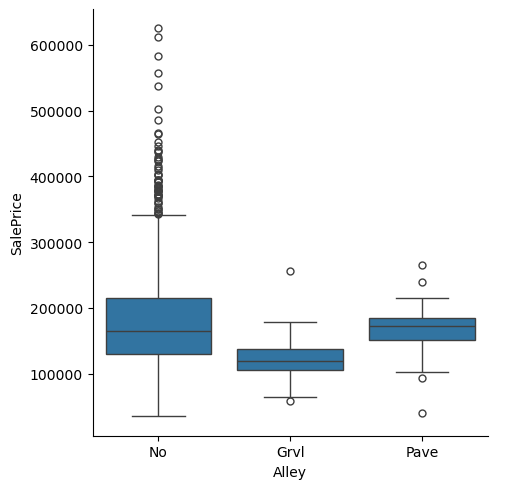

In [290]:
sns.catplot(data=train_df, x="Alley", y="SalePrice", kind="box")

In [291]:
train_df['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [292]:
train_df['Fence'].fillna('No', inplace=True)
test_df['Fence'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\3730986352.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Fence'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\3730986352.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

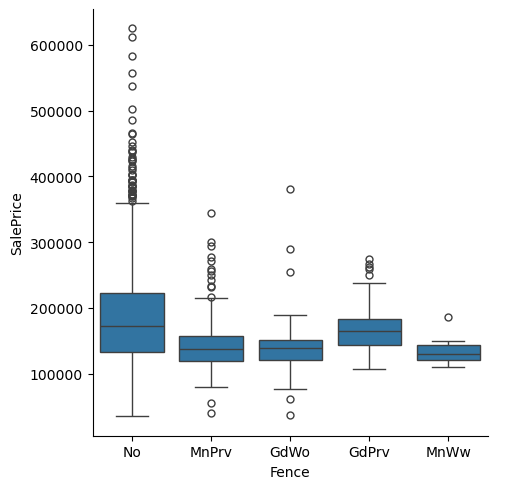

In [293]:
sns.catplot(data=train_df, x="Fence", y="SalePrice", kind="box")

In [294]:
train_df['MasVnrType'].unique()

array(['BrkFace', nan, 'Stone', 'BrkCmn'], dtype=object)

In [295]:
train_df['MasVnrType'].fillna('No', inplace=True)
test_df['MasVnrType'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2175816292.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrType'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2175816292.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

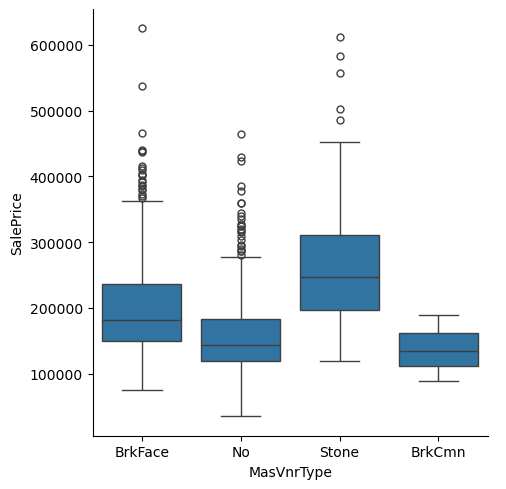

In [296]:
sns.catplot(data=train_df, x="MasVnrType", y="SalePrice", kind="box")

In [297]:
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\3657060107.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrArea'].fillna(0, inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\3657060107.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [298]:
train_df['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [299]:
train_df['FireplaceQu'].fillna('No', inplace=True)
test_df['FireplaceQu'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2825947256.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['FireplaceQu'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2825947256.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

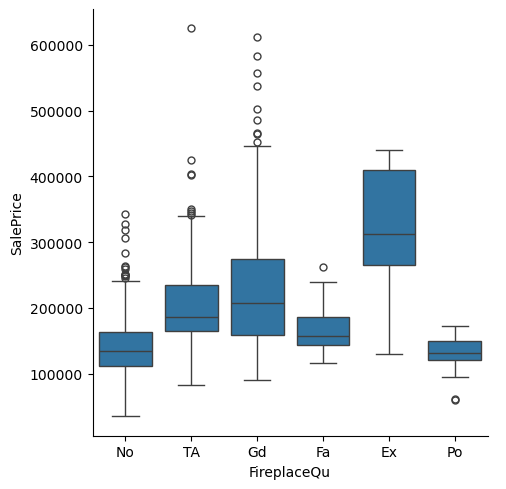

In [300]:
sns.catplot(data=train_df, x="FireplaceQu", y="SalePrice", kind="box")

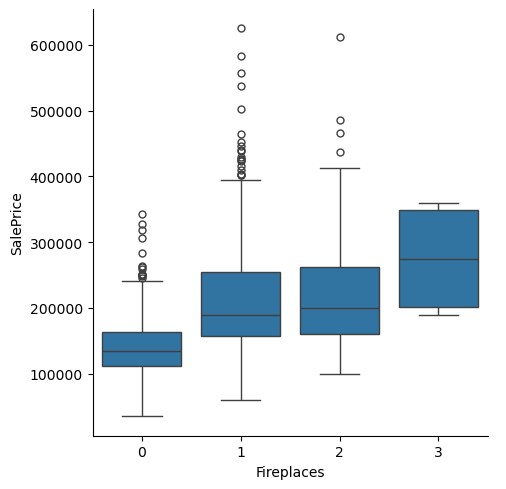

In [301]:
sns.catplot(data=train_df, x="Fireplaces", y="SalePrice", kind="box")

In [302]:
train_df['LotFrontage'].fillna(0, inplace=True)
test_df['LotFrontage'].fillna(0, inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\1334701034.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['LotFrontage'].fillna(0, inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\1334701034.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [303]:
train_df['GarageYrBlt'].corr(train_df['YearBuilt'])

0.8289827595060575

In [304]:
train_df['GarageCond'].unique()

array(['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'], dtype=object)

In [305]:
train_df['GarageCond'].fillna('No', inplace=True)
test_df['GarageCond'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\1255948083.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageCond'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\1255948083.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

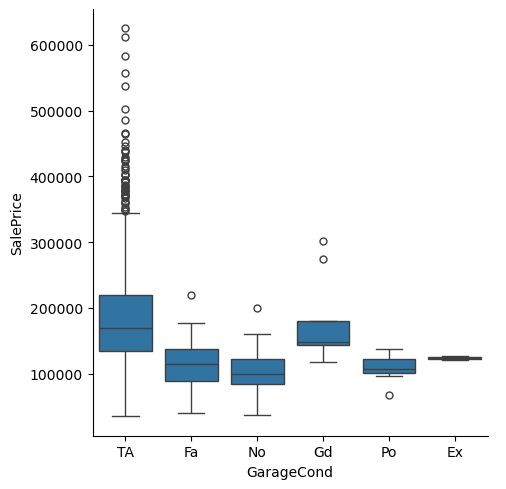

In [306]:
sns.catplot(data=train_df, x="GarageCond", y="SalePrice", kind="box")

In [307]:
train_df['GarageType'].fillna('No', inplace=True)
test_df['GarageType'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\3721453499.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageType'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\3721453499.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

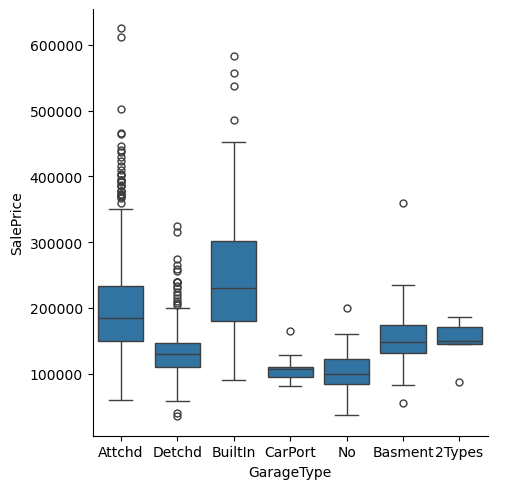

In [308]:
sns.catplot(data=train_df, x="GarageType", y="SalePrice", kind="box")

In [309]:
train_df['GarageFinish'].fillna('No', inplace=True)
test_df['GarageFinish'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2912414829.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageFinish'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2912414829.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

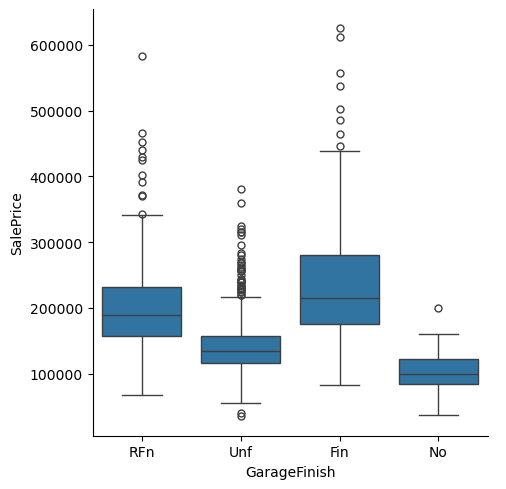

In [310]:
sns.catplot(data=train_df, x="GarageFinish", y="SalePrice", kind="box")

In [311]:
train_df['GarageQual'].fillna('No', inplace=True)
test_df['GarageQual'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\94532614.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageQual'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\94532614.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

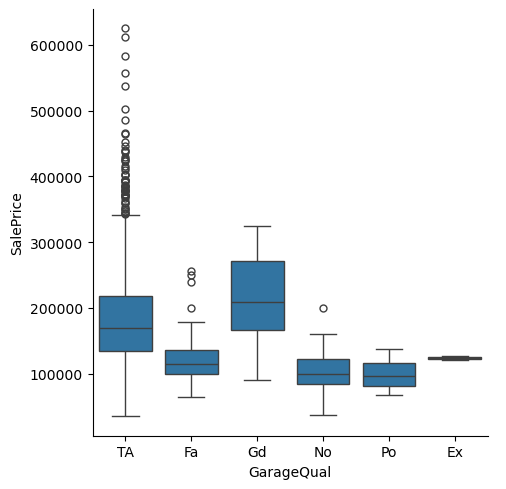

In [312]:
sns.catplot(data=train_df, x="GarageQual", y="SalePrice", kind="box")

In [313]:
train_df['BsmtFinType2'].unique()

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [314]:
train_df['BsmtFinType2'].fillna('Unf', inplace=True)
test_df['BsmtFinType2'].fillna('Unf', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\1071294587.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtFinType2'].fillna('Unf', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\1071294587.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

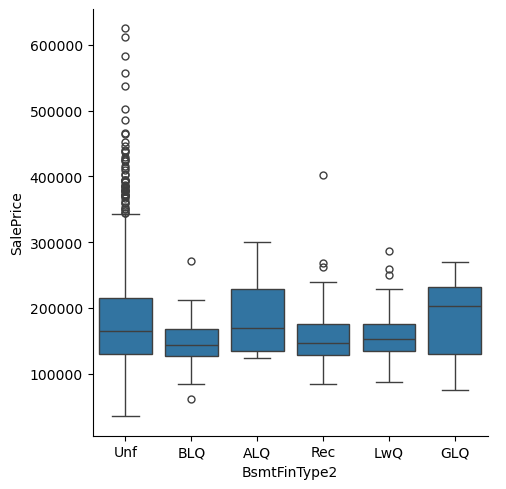

In [315]:
sns.catplot(data=train_df, x="BsmtFinType2", y="SalePrice", kind="box")

In [316]:
train_df['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [317]:
train_df['BsmtExposure'].fillna('No', inplace=True)
test_df['BsmtExposure'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2040818772.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtExposure'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2040818772.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

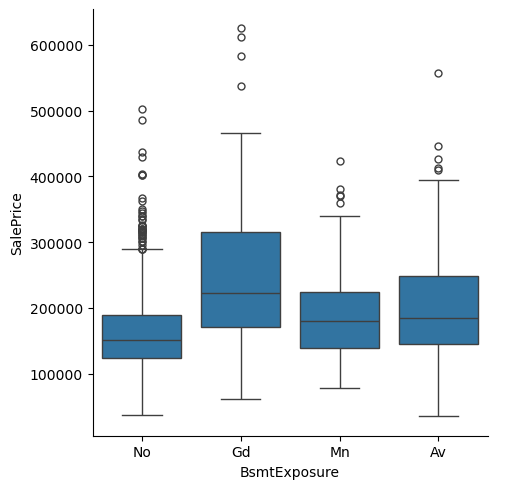

In [318]:
sns.catplot(data=train_df, x="BsmtExposure", y="SalePrice", kind="box")

In [319]:
train_df['BsmtQual'].unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

In [320]:
train_df['BsmtQual'].fillna('No', inplace=True)
test_df['BsmtQual'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2878576625.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtQual'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2878576625.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

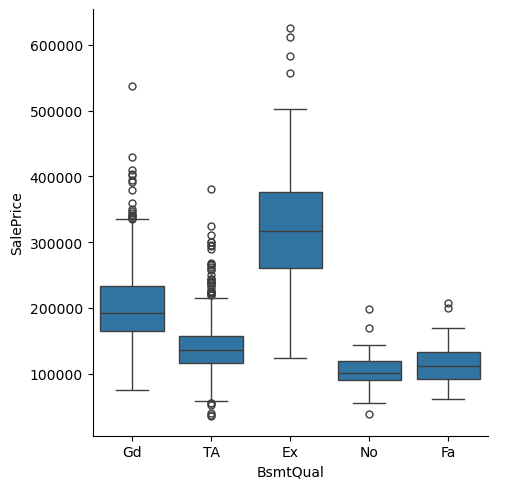

In [321]:
sns.catplot(data=train_df, x="BsmtQual", y="SalePrice", kind="box")

In [322]:
train_df['BsmtCond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [323]:
train_df['BsmtCond'].fillna('No', inplace=True)
test_df['BsmtCond'].fillna('No', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2806626140.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtCond'].fillna('No', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\2806626140.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

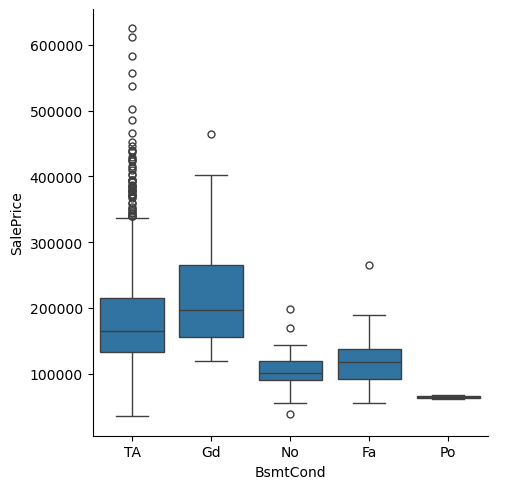

In [324]:
sns.catplot(data=train_df, x="BsmtCond", y="SalePrice", kind="box")

In [325]:
train_df['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [326]:
train_df['BsmtFinType1'].fillna('Unf', inplace=True)
test_df['BsmtFinType1'].fillna('Unf', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\3531540711.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtFinType1'].fillna('Unf', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\3531540711.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

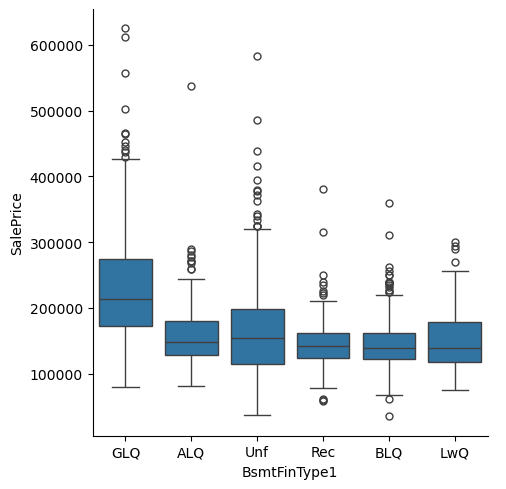

In [327]:
sns.catplot(data=train_df, x="BsmtFinType1", y="SalePrice", kind="box")

In [328]:
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\3657060107.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrArea'].fillna(0, inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\3657060107.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [329]:
train_df['Electrical'].fillna('SBrkr', inplace=True)
test_df['Electrical'].fillna('SBrkr', inplace=True)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\4245203846.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Electrical'].fillna('SBrkr', inplace=True)
C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\4245203846.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [330]:
train_df = train_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])

In [331]:
train_df['houseage'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['houseage'] = test_df['YrSold'] - test_df['YearBuilt']

In [332]:
train_df['houseremodelage'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['houseremodelage'] = test_df['YrSold'] - test_df['YearRemodAdd']

In [333]:
train_df['totalsf'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
test_df['totalsf'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']

In [334]:
train_df['totalarea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']
test_df['totalarea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']

In [335]:
train_df['totalbaths'] = train_df['BsmtFullBath'] + train_df['FullBath'] + 0.5 * (train_df['BsmtHalfBath'] + train_df['HalfBath']) 
test_df['totalbaths'] = test_df['BsmtFullBath'] + test_df['FullBath'] + 0.5 * (test_df['BsmtHalfBath'] + test_df['HalfBath']) 

In [336]:
train_df['totalporchsf'] = train_df['OpenPorchSF'] + train_df['3SsnPorch'] + train_df['EnclosedPorch'] + train_df['ScreenPorch'] + train_df['WoodDeckSF']
test_df['totalporchsf'] = test_df['OpenPorchSF'] + test_df['3SsnPorch'] + test_df['EnclosedPorch'] + test_df['ScreenPorch'] + test_df['WoodDeckSF']

In [337]:
train_df = train_df.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

<Axes: >

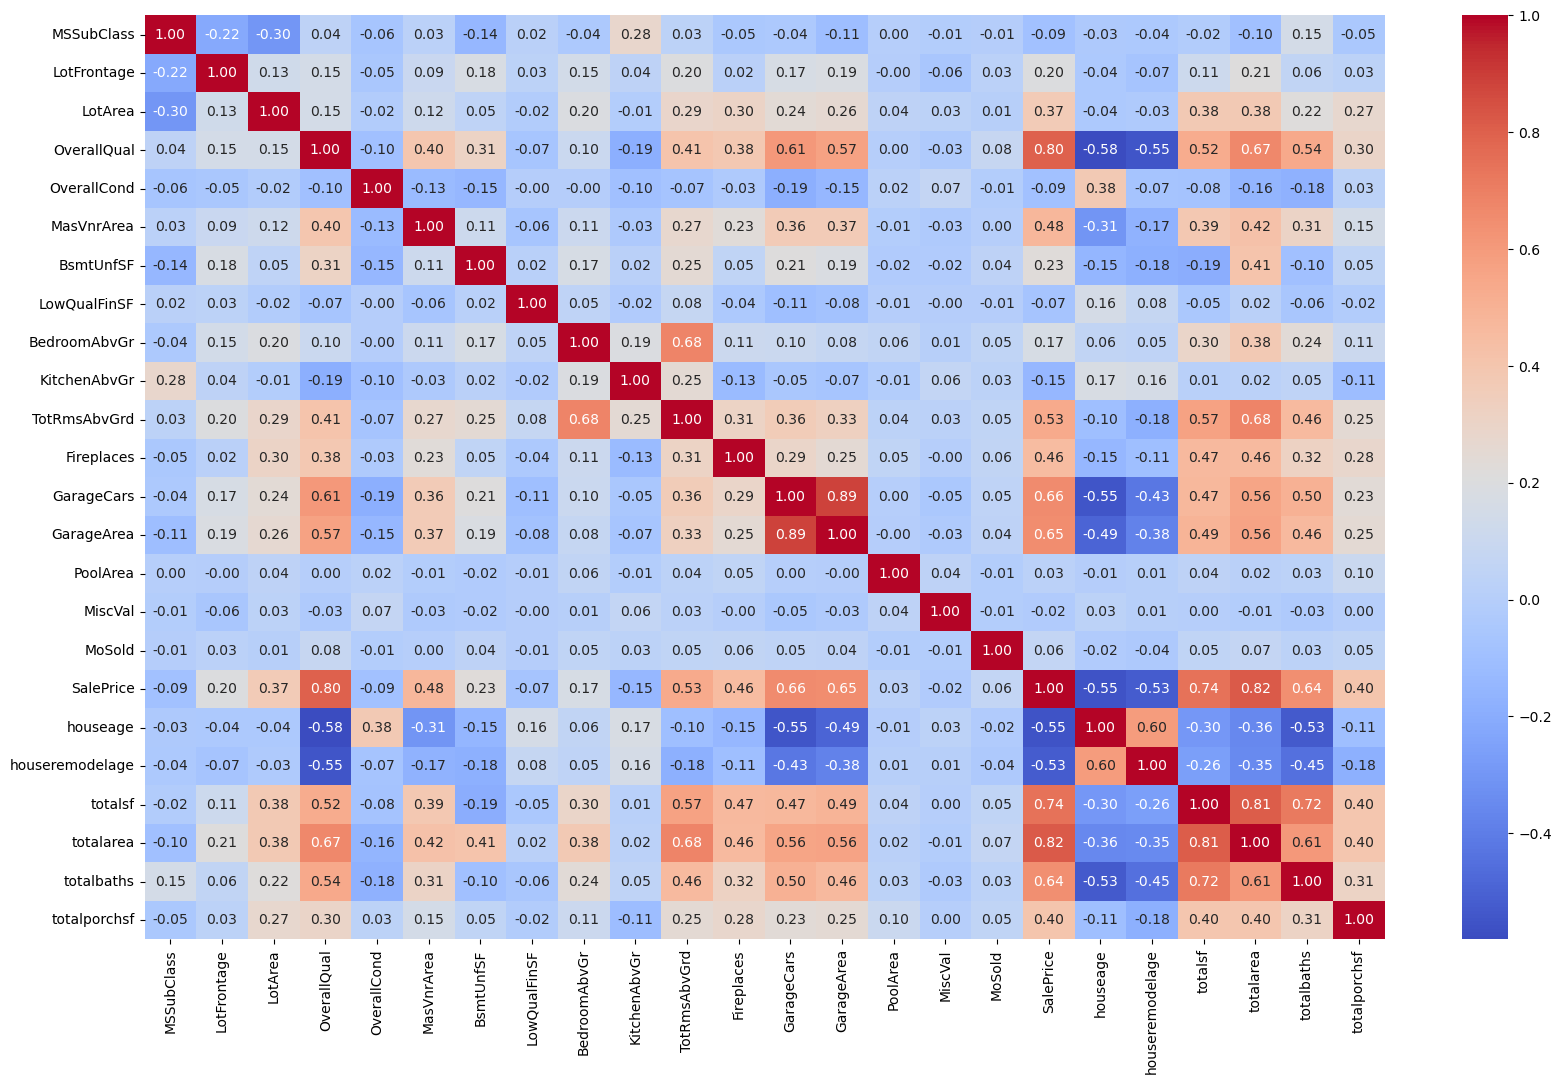

In [338]:
correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [339]:
train_df = train_df.drop(columns=['GarageArea'])
test_df = test_df.drop(columns=['GarageArea'])

<Axes: xlabel='SalePrice', ylabel='Count'>

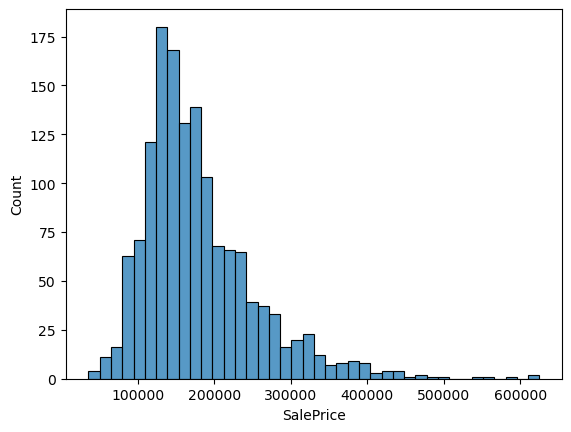

In [340]:
sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

In [341]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

<Axes: xlabel='SalePrice', ylabel='Count'>

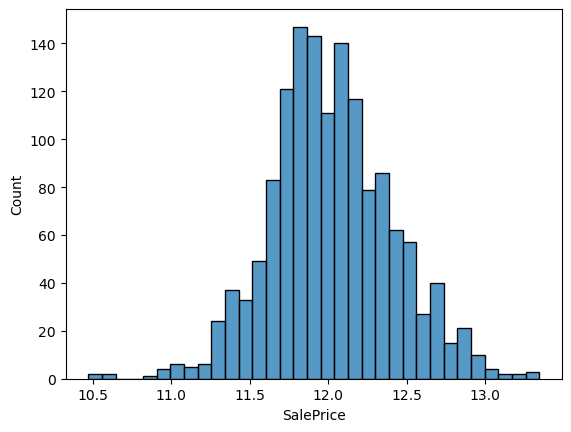

In [342]:
sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

In [343]:
train_df.dtypes[train_df.dtypes=='object']

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [344]:
train_df.dtypes[train_df.dtypes !='object']

MSSubClass           int64
LotFrontage        float64
LotArea              int64
OverallQual          int64
OverallCond          int64
MasVnrArea         float64
BsmtUnfSF            int64
LowQualFinSF         int64
BedroomAbvGr         int64
KitchenAbvGr         int64
TotRmsAbvGrd         int64
Fireplaces           int64
GarageCars           int64
PoolArea             int64
MiscVal              int64
MoSold               int64
SalePrice          float64
houseage             int64
houseremodelage      int64
totalsf              int64
totalarea            int64
totalbaths         float64
totalporchsf         int64
dtype: object

In [345]:
ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

In [346]:
ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [347]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

In [348]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()) #0-1
])

In [349]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) # categorik veriler ordinal sıralanır
])

In [350]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) #categorik veriler ayrı sutunlara ayrılır
])

In [351]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [352]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [353]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [354]:
X_preprocessed = pipeline.fit_transform(X)

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [356]:
lr = LinearRegression()
# Cross-validation kullanarak modelin performansını değerlendirme
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Negatif MSE değerini pozitif hale getirme ve RMSE hesaplama
rmse_scores = np.sqrt(-scores)

# En düşük RMSE skoruna sahip modeli bul
lr_best_rmse_index = np.argmin(rmse_scores)  # En düşük RMSE'nin olduğu katlamanın indeksi
lr_best_rmse = rmse_scores[lr_best_rmse_index]

# Sonuçları yazdırma
print("Cross-Validation RMSE Scores: ", rmse_scores)
print("Mean RMSE: ", np.mean(rmse_scores))


Cross-Validation RMSE Scores:  [3.41135207e+08 7.38996073e+08 4.28069575e+08 2.64601319e+08
 2.89332406e+08]
Mean RMSE:  412426915.9895853


In [357]:
# Optuna optimizasyon fonksiyonu
def objective(trial):
    # Optuna'nın optimize edeceği hiperparametreler
    max_depth = trial.suggest_int('max_depth', 5, 20)  # 5 ile 20 arasında max_depth dene
    n_estimators = trial.suggest_int('n_estimators', 100, 500)  # 100 ile 500 arasında n_estimators dene
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # 2 ile 10 arasında min_samples_split dene
    
    # RandomForestRegressor modelini hiperparametrelerle başlat
    RFR = RandomForestRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    # Cross-validation kullanarak modelin performansını değerlendirme (negatif MSE)
    score = cross_val_score(RFR, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    #scoring: Modelin performansını değerlendirecek metrik (örneğin, 'accuracy', 'neg_mean_squared_error', 'f1', 'roc_auc', vb.).
    # Pozitif MSE'yi döndür
    return np.sqrt(-score)

# Optuna çalışma alanı oluşturma
study = optuna.create_study(direction='minimize')

# Optimizasyon işlemi (denenecek trial sayısı n_trials ile belirlenir)
study.optimize(objective, n_trials=20)

# En iyi sonucu elde etme
print("Best trial:")
rfr_trial = study.best_trial


# En iyi hiperparametreleri al
best_params = rfr_trial.params

# En iyi modelin oluşturulması
best_rf_model = RandomForestRegressor(
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    random_state=13
)

# Modeli eğitme
best_rf_model.fit(X_train, y_train)

# Test setinde tahmin yapma
y_pred_best_rf = best_rf_model.predict(X_test)

# RMSE hesaplama
rmse_best_rf = mean_squared_error(y_test, y_pred_best_rf, squared=False)
print("Best Random Forest RMSE:", rmse_best_rf)

print(f"Best hyperparameters: {rfr_trial.params}")


[I 2024-09-27 20:23:06,120] A new study created in memory with name: no-name-f135592a-b997-4f50-99a0-d577d95ef332
[I 2024-09-27 20:23:13,582] Trial 0 finished with value: 0.14242516355392973 and parameters: {'max_depth': 6, 'n_estimators': 217, 'min_samples_split': 2}. Best is trial 0 with value: 0.14242516355392973.
[I 2024-09-27 20:23:22,360] Trial 1 finished with value: 0.13573366087598546 and parameters: {'max_depth': 11, 'n_estimators': 176, 'min_samples_split': 8}. Best is trial 1 with value: 0.13573366087598546.
[I 2024-09-27 20:23:29,653] Trial 2 finished with value: 0.13596391419559023 and parameters: {'max_depth': 16, 'n_estimators': 149, 'min_samples_split': 10}. Best is trial 1 with value: 0.13573366087598546.
[I 2024-09-27 20:23:38,346] Trial 3 finished with value: 0.14234380606405014 and parameters: {'max_depth': 6, 'n_estimators': 260, 'min_samples_split': 7}. Best is trial 1 with value: 0.13573366087598546.
[I 2024-09-27 20:23:58,036] Trial 4 finished with value: 0.1339

Best trial:
Best Random Forest RMSE: 0.1513372385992272
Best hyperparameters: {'max_depth': 18, 'n_estimators': 494, 'min_samples_split': 3}


C:\Users\ralpa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [358]:
def objective(trial):
    learning_rate =trial.suggest_float("learning_rate",0.05,0.3)
    n_estimators =trial.suggest_int("n_estimators",200,400)
    max_depth = trial.suggest_int("max_depth",3,5)
    min_child_weight = trial.suggest_int("min_child_weight",1,5)
    gamma = trial.suggest_float("gamma",0,0.5)
    subsample = trial.suggest_float("subsample",0.7,1)
    colsample_bytree =trial.suggest_float("colsample_bytree",0.7,1)
    xgb =XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        
    )
    score = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return np.sqrt(-score)

study=optuna.create_study(direction="minimize")
study.optimize(objective,n_trials=20)

print("Best trial :")
xgb_trial = study.best_trial

# En iyi hiperparametreleri kullanarak modeli eğitme
best_params = xgb_trial.params  # En iyi hiperparametreler
best_xgb = XGBRegressor(
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree']
)

# Modeli eğitim verileri ile eğitme
best_xgb.fit(X_train, y_train)

# Modelin test verileri ile tahmin yapması
y_pred = best_xgb.predict(X_test)

# Modelin performansını değerlendirme (RMSE hesaplama)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test set RMSE: {rmse}")
print(f"Best hyperparametrs : {xgb_trial.params}")
    

[I 2024-09-27 20:29:37,030] A new study created in memory with name: no-name-2fc0997a-9c7b-4e70-abf1-f8eaa25fbd11
[I 2024-09-27 20:29:37,703] Trial 0 finished with value: 0.1311810922974754 and parameters: {'learning_rate': 0.12977495547380857, 'n_estimators': 230, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.3590262042627784, 'subsample': 0.7109601316402288, 'colsample_bytree': 0.7203765735028558}. Best is trial 0 with value: 0.1311810922974754.
[I 2024-09-27 20:29:38,270] Trial 1 finished with value: 0.13714242172051955 and parameters: {'learning_rate': 0.297429468063508, 'n_estimators': 217, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.37300711646367607, 'subsample': 0.9440607428175285, 'colsample_bytree': 0.9032179853851048}. Best is trial 0 with value: 0.1311810922974754.
[I 2024-09-27 20:29:38,839] Trial 2 finished with value: 0.13563890299180656 and parameters: {'learning_rate': 0.2949168227227254, 'n_estimators': 219, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.

Best trial :
Test set RMSE: 0.13476988907851073
Best hyperparametrs : {'learning_rate': 0.1890241536940629, 'n_estimators': 262, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.00541319483500452, 'subsample': 0.8401149394535496, 'colsample_bytree': 0.7827147884391064}


In [359]:
def objective(trial):
    # Hiperparametrelerin tanımlanması
    alpha = trial.suggest_categorical("alpha", [0.05, 0.1, 1, 3, 5, 10])
    solver = trial.suggest_categorical("solver", ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'])
    
    # Ridge modelinin oluşturulması
    ridge = Ridge(alpha=alpha, solver=solver)
    
    # Cross-validation ile modelin performansını değerlendirme
    score = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return np.sqrt(-score)

# Optuna çalıştırma
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# En iyi sonuçları yazdırma
print("Best trial:")
rdg_trial = study.best_trial

# En iyi hiperparametreleri kullanarak Ridge modelini oluşturma
best_params = rdg_trial.params  # En iyi hiperparametreler
ridge_model = Ridge(
    alpha=best_params['alpha'],
    solver=best_params['solver']
)

# Modeli eğitim verileri ile eğitme
ridge_model.fit(X_train, y_train)

# Modelin test verileri ile tahmin yapması
y_pred = ridge_model.predict(X_test)

# Modelin performansını değerlendirme (RMSE hesaplama)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test set RMSE: {rmse}")


print(f"RMSE: {rdg_trial.value}")
print(f"Best hyperparameters: {rdg_trial.params}")


[I 2024-09-27 20:29:54,499] A new study created in memory with name: no-name-bc2b8c2a-c695-4a6c-ac9d-2cd8369670ec
[I 2024-09-27 20:29:54,704] Trial 0 finished with value: 0.1185989111904613 and parameters: {'alpha': 0.1, 'solver': 'lsqr'}. Best is trial 0 with value: 0.1185989111904613.
C:\Users\ralpa\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ralpa\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ralpa\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ralpa\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best trial:
Test set RMSE: 0.12524413081597738
RMSE: 0.11188965444937801
Best hyperparameters: {'alpha': 10, 'solver': 'auto'}


In [360]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# Hedef fonksiyonu tanımlama
def objective(space):
    GBR = GradientBoostingRegressor(
        max_depth=int(space['max_depth']),
        n_estimators=int(space['n_estimators']),
        min_samples_leaf=int(space['min_samples_leaf']),
        learning_rate=space['learning_rate'],
        max_features=space['max_features']
    )
    
    # Cross-validation ile skoru hesapla
    score = cross_val_score(GBR, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return {'loss': -score, 'status': STATUS_OK}

# Hiperparametre aralıklarını belirleme
space = {
    'max_depth': hp.choice('max_depth', [12, 15, 20]),
    'n_estimators': hp.choice('n_estimators', [200, 300, 1000]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [10, 25, 50]),
    'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.1]),
    'max_features': hp.uniform('max_features', 0.01, 0.7)
}

# Optimize etme sürecini başlatma
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

best_params = {
    'learning_rate': [0.001, 0.01, 0.1][best['learning_rate']],
    'max_depth': [12, 15, 20][best['max_depth']],
    'max_features': best['max_features'],  # Bu zaten bir float değer
    'min_samples_leaf': [10, 25, 50][best['min_samples_leaf']],
    'n_estimators': [200, 300, 1000][best['n_estimators']]
}
best_GBR = GradientBoostingRegressor(
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    min_samples_leaf=best_params['min_samples_leaf'],
    learning_rate=best_params['learning_rate'],
    max_features=best_params['max_features']
)

# Modeli eğitim verileriyle eğitme
best_GBR.fit(X_train, y_train)

# Test verileriyle tahmin yapma
y_pred = best_GBR.predict(X_test)

# En iyi modeli oluşturma
best_GBR = GradientBoostingRegressor(
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    min_samples_leaf=best_params['min_samples_leaf'],
    learning_rate=best_params['learning_rate'],
    max_features=best_params['max_features']
)

# Modeli eğitim verileriyle eğitme
best_GBR.fit(X_train, y_train)

# Test verileriyle tahmin yapma
y_pred = best_GBR.predict(X_test)

# Performansı ölçme (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Best Model RMSE:", rmse)

# En iyi hiperparametreleri yazdırma
print("Best Hyperparameters:", best_params)

100%|██████████| 20/20 [02:27<00:00,  7.38s/trial, best loss: 0.013082308358241474]
Best Model RMSE: 0.12783223137200805
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 20, 'max_features': 0.1559440410165913, 'min_samples_leaf': 25, 'n_estimators': 1000}


In [361]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

def objective(trial):
    lgbm_regressor = LGBMRegressor(
        boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        num_leaves=trial.suggest_int('num_leaves', 20, 40),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1),
        n_estimators=trial.suggest_int('n_estimators', 100, 300)
    )
    
    score = cross_val_score(lgbm_regressor, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return -score  # Minimization problem

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial: ")
lgbm_trial = study.best_trial

best_lgbm_model = LGBMRegressor(
    boosting_type=lgbm_trial.params['boosting_type'],
    num_leaves=lgbm_trial.params['num_leaves'],
    learning_rate=lgbm_trial.params['learning_rate'],
    n_estimators=lgbm_trial.params['n_estimators']
)

# Modeli eğitme
best_lgbm_model.fit(X_train, y_train)

# Tahmin yapma
y_pred = best_lgbm_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")



[I 2024-09-27 20:32:42,108] A new study created in memory with name: no-name-e8d92510-80b2-4230-8fe3-4ef30ac85014


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.049870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-09-27 20:32:42,615] Trial 0 finished with value: 0.01576958345819778 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'learning_rate': 0.057629724336922344, 'n_estimators': 154}. Best is trial 0 with value: 0.01576958345819778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-27 20:32:43,153] Trial 1 finished with value: 0.015690008797971625 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'learning_rate': 0.09141837684228274, 'n_estimators': 171}. Best is trial 1 with value: 0.015690008797971625.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.049870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-09-27 20:32:43,763] Trial 2 finished with value: 2.856723226237427 and parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'learning_rate': 0.06052606727312326, 'n_estimators': 173}. Best is trial 1 with value: 0.015690008797971625.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.049870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-09-27 20:32:44,058] Trial 3 finished with value: 0.015646383591597614 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'learning_rate': 0.06295383138807022, 'n_estimators': 114}. Best is trial 3 with value: 0.015646383591597614.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.049870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-09-27 20:32:45,117] Trial 4 finished with value: 0.2370575361283742 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.07090713928489394, 'n_estimators': 280}. Best is trial 3 with value: 0.015646383591597614.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.049870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-09-27 20:32:45,677] Trial 5 finished with value: 0.015613122476927277 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'learning_rate': 0.08051675054330971, 'n_estimators': 211}. Best is trial 5 with value: 0.015613122476927277.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-27 20:32:46,849] Trial 6 finished with value: 0.2699992707849155 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'learning_rate': 0.06695150441134803, 'n_estimators': 278}. Best is trial 5 with value: 0.015613122476927277.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-27 20:32:47,971] Trial 7 finished with value: 0.8900516616928705 and parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'learning_rate': 0.047455917671800525, 'n_estimators': 282}. Best is trial 5 with value: 0.015613122476927277.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.049870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-09-27 20:32:48,456] Trial 8 finished with value: 0.015646550641981602 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'learning_rate': 0.043495370851312685, 'n_estimators': 194}. Best is trial 5 with value: 0.015613122476927277.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-27 20:32:48,872] Trial 9 finished with value: 6.904960907976011 and parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'learning_rate': 0.041010599056152765, 'n_estimators': 118}. Best is trial 5 with value: 0.015613122476927277.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.049870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to rem

[I 2024-09-27 20:32:49,405] Trial 10 finished with value: 0.016711801603812915 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.016245374639326834, 'n_estimators': 234}. Best is trial 5 with value: 0.015613122476927277.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.049870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-09-27 20:32:49,751] Trial 11 finished with value: 0.015774422335318134 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'learning_rate': 0.09023846481288153, 'n_estimators': 101}. Best is trial 5 with value: 0.015613122476927277.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-27 20:32:50,472] Trial 12 finished with value: 0.015601577775126408 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'learning_rate': 0.07719958531527404, 'n_estimators': 232}. Best is trial 12 with value: 0.015601577775126408.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.049870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-09-27 20:32:51,203] Trial 13 finished with value: 0.015652313292533516 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'learning_rate': 0.07970431892263573, 'n_estimators': 238}. Best is trial 12 with value: 0.015601577775126408.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-27 20:32:51,809] Trial 14 finished with value: 0.015844017319784715 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'learning_rate': 0.0996627556300636, 'n_estimators': 233}. Best is trial 12 with value: 0.015601577775126408.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-27 20:32:52,266] Trial 15 finished with value: 0.01597855459526513 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'learning_rate': 0.0787331658125866, 'n_estimators': 208}. Best is trial 12 with value: 0.015601577775126408.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.049870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-09-27 20:32:52,897] Trial 16 finished with value: 0.016113696022033205 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'learning_rate': 0.07851413877113678, 'n_estimators': 251}. Best is trial 12 with value: 0.015601577775126408.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-27 20:32:53,446] Trial 17 finished with value: 0.01570972978534747 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'learning_rate': 0.031020777803089, 'n_estimators': 209}. Best is trial 12 with value: 0.015601577775126408.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-27 20:32:54,079] Trial 18 finished with value: 0.01589539831403416 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.08812675169055414, 'n_estimators': 253}. Best is trial 12 with value: 0.015601577775126408.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-27 20:32:54,908] Trial 19 finished with value: 0.015546480074012372 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'learning_rate': 0.07179111568890459, 'n_estimators': 298}. Best is trial 19 with value: 0.015546480074012372.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [362]:
def objective(trial):
    # Hiperparametreleri tanımlama
    iterations = trial.suggest_int("iterations", 100, 1000)
    depth = trial.suggest_int("depth", 4, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5)

    # CatBoostRegressor modelini tanımlama
    catboost = CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        loss_function='RMSE',
        verbose=False  # Eğitim sırasında bilgi vermesini istemiyoruz
    )

    # Cross-validation ile skoru hesaplama
    score = cross_val_score(catboost, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return np.sqrt(-score)

# Optuna çalıştırma
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# En iyi hiperparametreleri al
best_params = {
    'iterations': study.best_trial.params['iterations'],
    'depth': study.best_trial.params['depth'],
    'learning_rate': study.best_trial.params['learning_rate']
}

# CatBoostRegressor modelini tanımlama
best_catboost = CatBoostRegressor(
    iterations=best_params['iterations'],
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    loss_function='RMSE',
    verbose=False  # Eğitim sırasında bilgi vermesini istemiyoruz
)

# Modeli eğitim verileriyle eğitme
best_catboost.fit(X_train, y_train)

# Test verileriyle tahmin yapma
y_pred = best_catboost.predict(X_test)

# Performansı ölçme (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Best Model RMSE:", rmse)

# En iyi hiperparametreleri yazdırma
print("Best Hyperparameters:", best_params)

[I 2024-09-27 20:32:55,312] A new study created in memory with name: no-name-8c94b108-fc01-4f79-9100-ee39a795d7cd
[I 2024-09-27 20:32:56,563] Trial 0 finished with value: 0.13623842624394794 and parameters: {'iterations': 225, 'depth': 4, 'learning_rate': 0.017340057858929246}. Best is trial 0 with value: 0.13623842624394794.
[I 2024-09-27 20:33:00,092] Trial 1 finished with value: 0.138711083717681 and parameters: {'iterations': 111, 'depth': 9, 'learning_rate': 0.4352109458138998}. Best is trial 0 with value: 0.13623842624394794.
[I 2024-09-27 20:33:06,650] Trial 2 finished with value: 0.1351298072894029 and parameters: {'iterations': 606, 'depth': 7, 'learning_rate': 0.49430073935990804}. Best is trial 2 with value: 0.1351298072894029.
[I 2024-09-27 20:33:31,634] Trial 3 finished with value: 0.13949136223235248 and parameters: {'iterations': 821, 'depth': 9, 'learning_rate': 0.46942692351794196}. Best is trial 2 with value: 0.1351298072894029.
[I 2024-09-27 20:33:34,733] Trial 4 fin

Best Model RMSE: 0.12655234948070088
Best Hyperparameters: {'iterations': 555, 'depth': 5, 'learning_rate': 0.0732798538287707}


In [363]:
vr = VotingRegressor([('gbr',best_GBR),
                      ('xgb',best_xgb),
                      ('ridge', ridge_model)],
                    weights=[2,3,1])
vr.fit(X_train, y_train)
y_pred_vr = vr.predict(X_test)
mean_squared_error(y_test, y_pred_vr, squared=False)

C:\Users\ralpa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.12586485818771043

In [364]:
estimators = [
    ('gbr', best_GBR),
    ('xgb', best_xgb),
    ('cat', best_catboost),
    ('lgb', best_lgbm_model),
    ('rfr', best_rf_model),
]
stackreg = StackingRegressor(
            estimators = estimators,
            final_estimator = vr
)
stackreg.fit(X_train, y_train)
y_pred_stack = stackreg.predict(X_test)
mean_squared_error(y_test, y_pred_stack, squared=False)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1999
[LightGBM] [Info] Number of data points in the train set: 1151, number of used features: 112
[LightGBM] [Info] Start training from score 12.042784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 106
[LightGBM] [Info] Start training from score 12.041813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\ralpa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.1285675324921057

In [365]:
df_test_preprocess = pipeline.transform(test_df)
y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_df[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('submission.csv', index=False)

C:\Users\ralpa\AppData\Local\Temp\ipykernel_12212\1901357043.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['SalePrice'] = y_stacking
